# Dynamic Hand Gestures Classification

##### version 2.1

#### Paper: [Dynamic hand gesture recognition based on 3D patternassembled trajectories](https://hal.archives-ouvertes.fr/hal-01666377/document)

#### Dataset: [Dynamic Hand Gestures repository for LMDHG dataset](https://www-intuidoc.irisa.fr/en/english-leap-motion-dynamic-hand-gesture-lmdhg-database/)

#### Preprocessing: [Code to convert Dataset*.txt to hands images](https://gitlab.com/aviogit/dynamic-hand-gestures) (@ [commit 6fc38b0e](https://gitlab.com/aviogit/dynamic-hand-gestures/commit/6fc38b0ee1725e39f0c5b8ee37d255f499b7046c))

Generated images have no label embedded, left-right hands have different colors and now fingers are also colored differently (also between left/right hand) and fingertips follow the same colore scheme. Fingertips leave traces across the entire gesture (as defined and labeled in the original LMDHG dataset) fading linearly in the alpha channel. Only one view is used per gesture: "top" view.


<table>
    <tr>
        <td><center>Catching</center></td>
        <td><center>Rotating</center></td>
    </tr>
    <tr>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Catching-716-datafile29.png"></img>
        </td>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Rotating-12858-datafile11.png"></img>
        </td>
    </tr>
    <tr>
        <td><center>Scroll Finger</center></td>
        <td><center>Shaking</center></td>
    </tr>
    <tr>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Scroll-Finger-412-datafile36.png"></img>
        </td>
        <td>
            <img width="100%" height="100%" src="https://gitlab.com/aviogit/dynamic-hand-gestures/-/raw/master/pics/colored-fingers-and-fingertips/Shaking-418-datafile41.png"></img>
        </td>
    </tr>
</table>


In [1]:
# -----------------------------
# Make everything deterministic
# -----------------------------
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

cuda_training_device = 1

os.environ['CUDA_DEVICE_ORDER']    = 'PCI_BUS_ID'
print(os.environ['PYTHONPATH'])
os.environ['PYTHONPATH']           = ''
print(os.environ['PYTHONPATH'])

import numpy as np
a_random_image_number_modifier = np.random.randint(100)
np.random.seed(2)

from matplotlib.pyplot import imshow

import torch
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#%matplotlib notebook
%matplotlib inline

/cm/local/apps/cuda/libs/current/pynvml



In [2]:
import torch
import pycuda
from pycuda import gpuarray
from pycuda import compiler
from pycuda.curandom import rand as curand

# -----------------------------
# --- initialize the device ---
# -----------------------------
import pycuda.autoinit
import pycuda.driver as drv

drv.init()
print("%d device(s) found." % drv.Device.count())
           
for ordinal in range(drv.Device.count()):
    dev = drv.Device(ordinal)
    print (ordinal, dev.name())

print(torch.cuda.is_available())
print(torch.cuda.device_count())

2 device(s) found.
0 Tesla V100-PCIE-32GB
1 Tesla V100-PCIE-32GB
True
2


In [3]:
import torch
import sys
print('__Python VERSION:',  sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:',       torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ',     torch.cuda.device_count())
print ('Current cuda device ',   torch.cuda.current_device())

__Python VERSION: 3.6.7 (default, Apr 12 2019, 22:03:02) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-28)]
__pyTorch VERSION: 1.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
__CUDNN VERSION: 7603
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


#### Choose the GPU for training

In [4]:
# Supposing we're training on the other, let's use the second available device...
torch.cuda.set_device('cuda:' + str(cuda_training_device))

print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ',     torch.cuda.device_count())
print ('Current cuda device ',   torch.cuda.current_device())

Active CUDA Device: GPU 1
Available devices  2
Current cuda device  1


In [5]:
import fastai
import pathlib

from fastai.vision import *
from fastai.metrics import error_rate
from fastai import __version__

from torchvision.models import vgg16_bn

import torchvision
from torchvision import models

from fastai.callbacks import *
from fastai.utils import show_install

In [6]:
!nvidia-smi

Tue Feb 18 18:25:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:5E:00.0 Off |                    0 |
| N/A   40C    P0    37W / 250W |    316MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |     11MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [7]:
show_install(0)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 2
torch devices : 2
  - gpu0      : 32480MB | Tesla V100-PCIE-32GB
  - gpu1      : 32480MB | Tesla V100-PCIE-32GB

=== Environment === 
platform      : Linux-3.10.0-957.1.3.el7.x86_64-x86_64-with-centos-7.6.1810-Core
distro        : CentOS Linux 7 Core
conda env     : Unknown
python        : /home/ranieri/ml/bin/python3
sys.path      : /cm/local/apps/cuda/libs/current/pynvml
/home/ranieri/ml/lib/python36.zip
/home/ranieri/ml/lib/python3.6
/home/ranieri/ml/lib/python3.6/lib-dynload
/cm/local/apps/python3/lib/python3.6

/home/ranieri/ml/lib/python3.6/site-packages
/home/ranieri/Ranger-Deep-Learning-Optimizer
/home/ranieri/ml/lib/python3.6/site-packages/IPython/extensions
/home/ranieri/.ipython
```

Please make sure to include opening/closing ``` w

In [8]:
print(f'Fast.ai version: {fastai.__version__}')

Fast.ai version: 1.0.60


#### A few utilities functions...

In [9]:
from subprocess import check_output
nvidia_smi_ = [0, 0]

def get_num_gpus(debug=False):
    # torch.cuda.device_count() works strange :)
    n_gpus = check_output(['nvidia-smi', '--list-gpus']).decode('UTF-8').count('\n')
    if debug:
        print(n_gpus)
    return int(n_gpus)

def get_gpus_vram_stats(id=0, debug=False):
    n_gpus = get_num_gpus(debug)
    mem_stats = check_output(['nvidia-smi', '--id='+str(id), '--query-gpu=memory.total,memory.free,memory.used', '--format=csv,noheader']).decode('UTF-8').split() #.count('\n')
    mem_total = mem_stats[0]
    mem_free  = mem_stats[2]
    mem_used  = mem_stats[4]
    if debug:
        print(n_gpus)
        print(mem_stats)
        print(mem_total)
        print(mem_free)
        print(mem_used)
    return int(mem_total), int(mem_free), int(mem_used)
    
def nvidia_smi(nvidia_smi_, gpu_num=0, debug=False):
    old_nvidia_smi_ = nvidia_smi_[1]
    nvidia_smi_now  = check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader']).decode('UTF-8')
    nvidia_smi_now_gpus = nvidia_smi_now.splitlines()
    if debug:
        print(nvidia_smi_now_gpus)
    for i in range(get_num_gpus()):
        if i == gpu_num:
            nvidia_smi_[0]  = int(nvidia_smi_now_gpus[i])
            nvidia_smi_[1]  = int(nvidia_smi_now_gpus[i]) - old_nvidia_smi_
    return nvidia_smi_ 

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))

torch.cuda.empty_cache()

nvidia-smi memory usage/increment: [11, 11]


## Build the DataBunch and create the Learner object

In [10]:
dataset_dir = Path('/home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper')
!ls -lh '{dataset_dir}'

total 1.5K
drwxr-xr-x  2 ranieri imati  1 Feb 18 18:23 models
drwxr-xr-x 16 ranieri imati 14 Feb 18 18:11 train
drwxr-xr-x 16 ranieri imati 14 Feb 18 18:13 valid


In [11]:
arch_str = "resnet-50"
if arch_str == "resnet-34":
    cnn_model = models.resnet34
    img_size  = 112
    epochs    = 10
    bs        = 64
    # bs      = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart
else:
    cnn_model = models.resnet50
    img_size  = 112
    epochs    = 10
    bs        = 64
    #bs       = 4   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [15]:
def create_dataset(bs, image_size):
    tfms = get_transforms()
    #ll = ImageList.from_folder(dataset_dir).split_by_rand_pct(0.3).label_from_folder()
    ll = ImageList.from_folder(dataset_dir).split_by_folder().label_from_folder()
    if image_size:
        data = (ll.transform(tfms, size=image_size).databunch(bs=bs)).normalize(imagenet_stats)
    else:
        data = (ll.transform(tfms).databunch(bs=bs)).normalize(imagenet_stats)

    data.show_batch(rows=3, figsize=(7,6))

    print(f'The dataset has {len(data.classes)} ({data.c}) classes: {data.classes}')
    print(f'Training   set len is: (x: {len(data.train_dl.dl.dataset.x)}, y: {len(data.train_dl.dl.dataset.y)})')
    print(f'Validation set len is: (x: {len(data.valid_dl.dl.dataset.x)}, y: {len(data.valid_dl.dl.dataset.y)})')
    print(f'Dataset image size is  (train: {data.train_dl.dl.dataset.x[0].size}, valid: {data.valid_dl.dl.dataset.x[0].size})')
    
    return data

In [16]:
def show_augmented_images():
    this_batch = data.one_batch()
    this_batch_images = this_batch[0]
    this_batch_labels = this_batch[1]
    print(f'Batch  shape: {this_batch_images.shape}')
    print(f'Image  shape: {this_batch_images[0].shape}')
    print(f'Labels shape: {this_batch_labels.shape}')
    print(f'Label[0]: {this_batch_labels[0]} -> {data.classes[this_batch_labels[0]]}')
    Image(this_batch_images[0]).show(figsize=(11,11))
    print(f'Label[2]: {this_batch_labels[2]}')
    Image(this_batch_images[2]).show(figsize=(11,11))

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 779, y: 779)
Validation set len is: (x: 355, y: 355)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


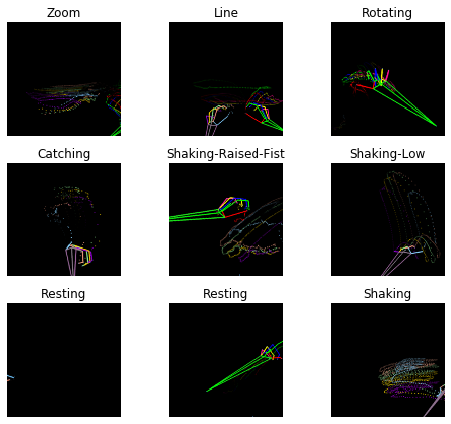

In [17]:
data = create_dataset(bs, img_size)

Batch  shape: torch.Size([64, 3, 112, 112])
Image  shape: torch.Size([3, 112, 112])
Labels shape: torch.Size([64])
Label[0]: 9 -> Shaking
Label[2]: 13


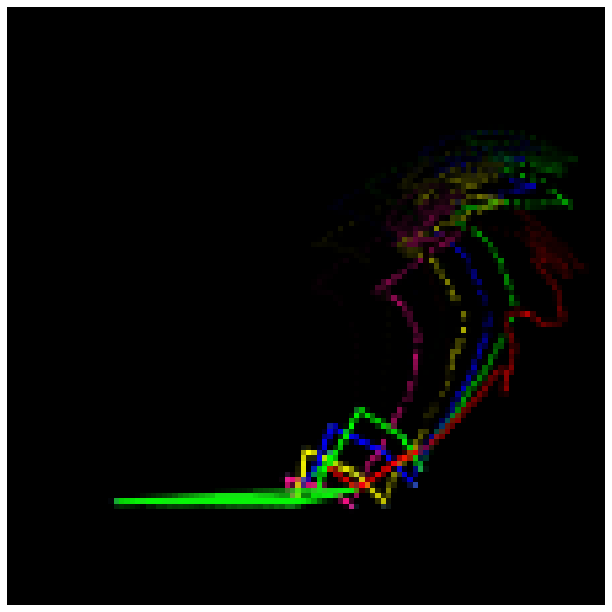

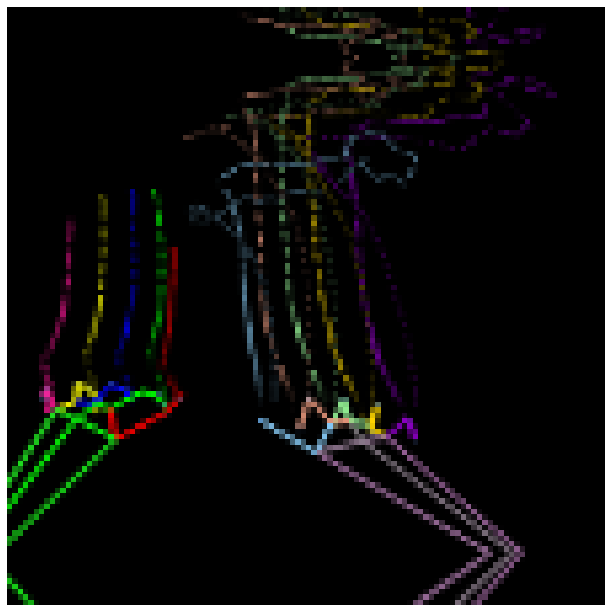

In [18]:
show_augmented_images()

In [19]:
from datetime import datetime
currtime = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

runtime_name = 'local'

if runtime_name   == 'local':
  savepath           = dataset_dir / '..' / 'models'
elif runtime_name == 'colab':
  savepath           = Path(base_path) / dataset_dir / 'models'
else:
  savepath           = Path('/tmp')

savepath.mkdir(exist_ok=True)

model_name = arch_str

print(f'Models will be saved at: {savepath} with name: {model_name}')

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))

learn = cnn_learner(data, cnn_model, metrics=accuracy)

print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
print('Learner ready.')

Models will be saved at: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models with name: resnet-50
nvidia-smi memory usage/increment: [1130, 1119]
nvidia-smi memory usage/increment: [1206, 87]
Learner ready.


Pointing torch.Size([1080, 1920])


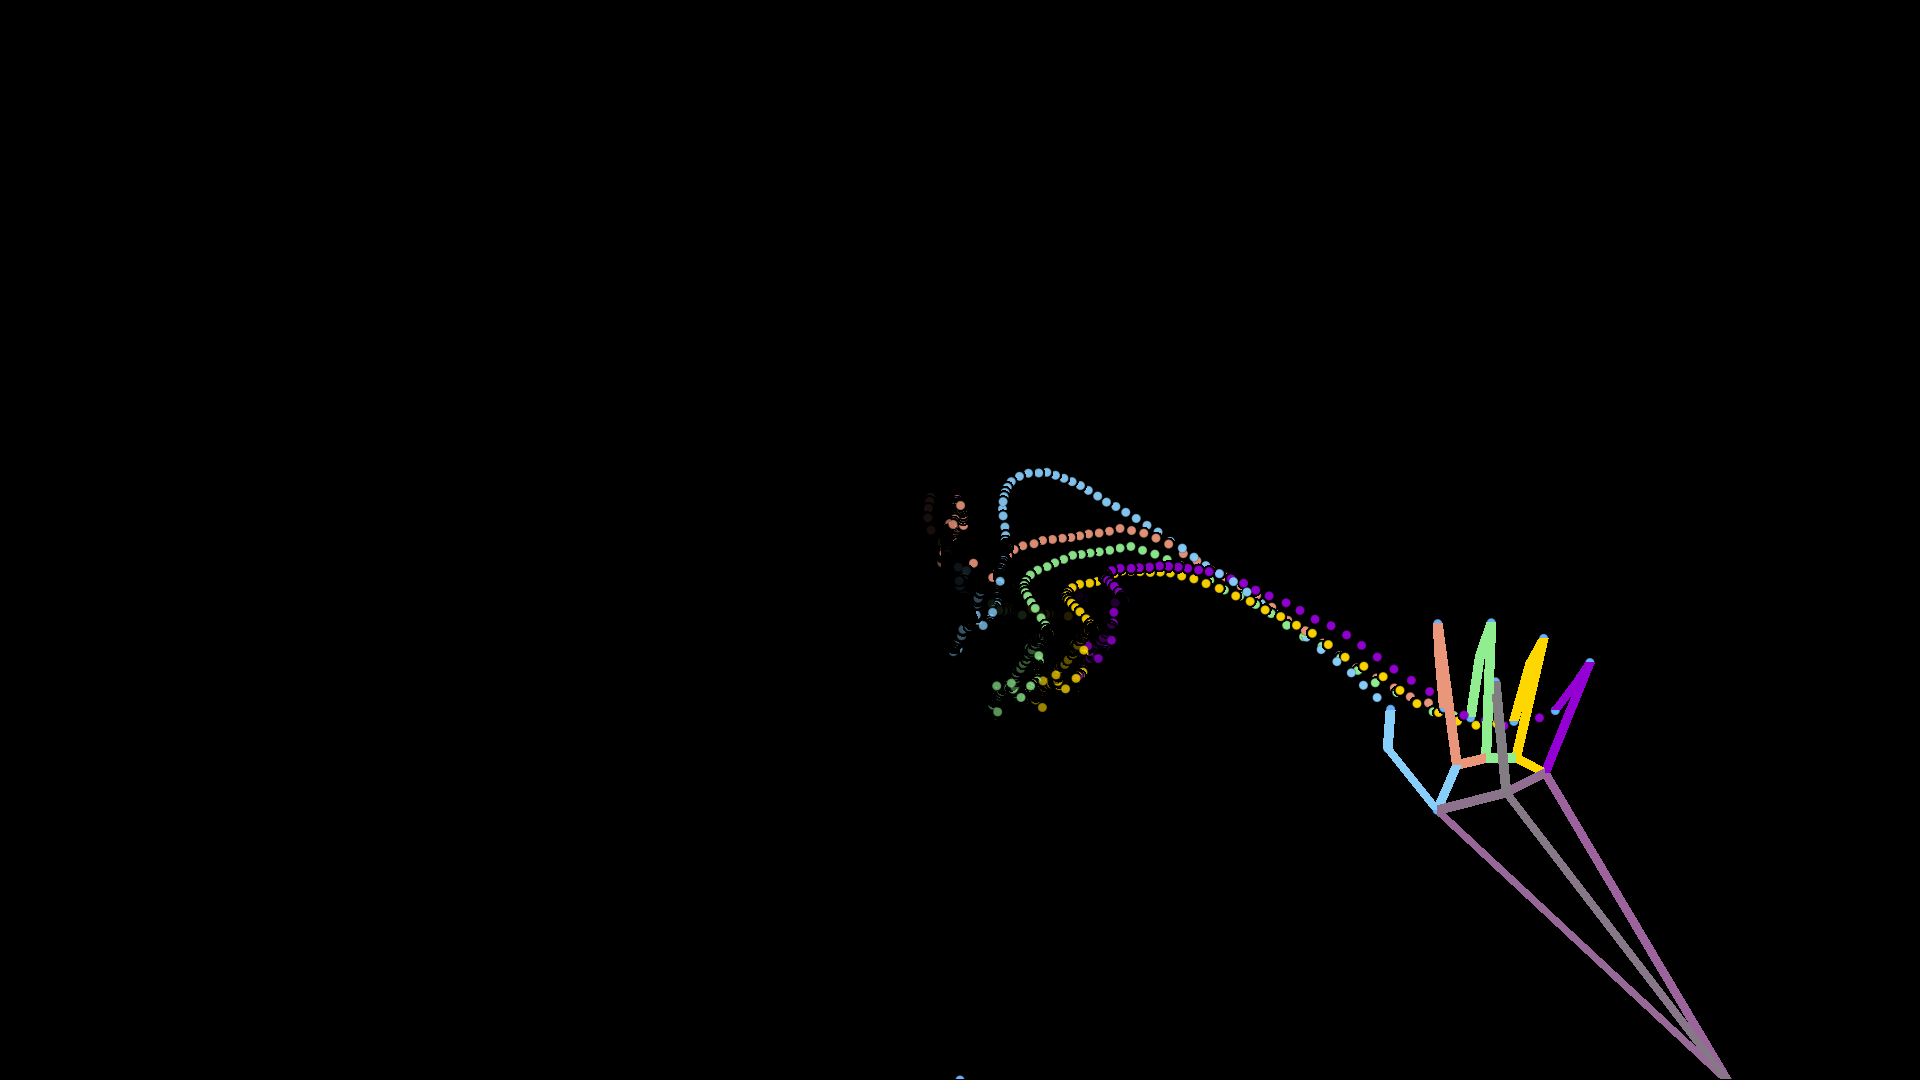

In [20]:
rnd_idx = np.random.randint(len(data.train_dl.dl.dataset.x))
img   = data.train_dl.dl.dataset.x[rnd_idx]
label = data.train_dl.dl.dataset.y[rnd_idx]
print(label, img.size)
img

Catching torch.Size([1080, 1920])


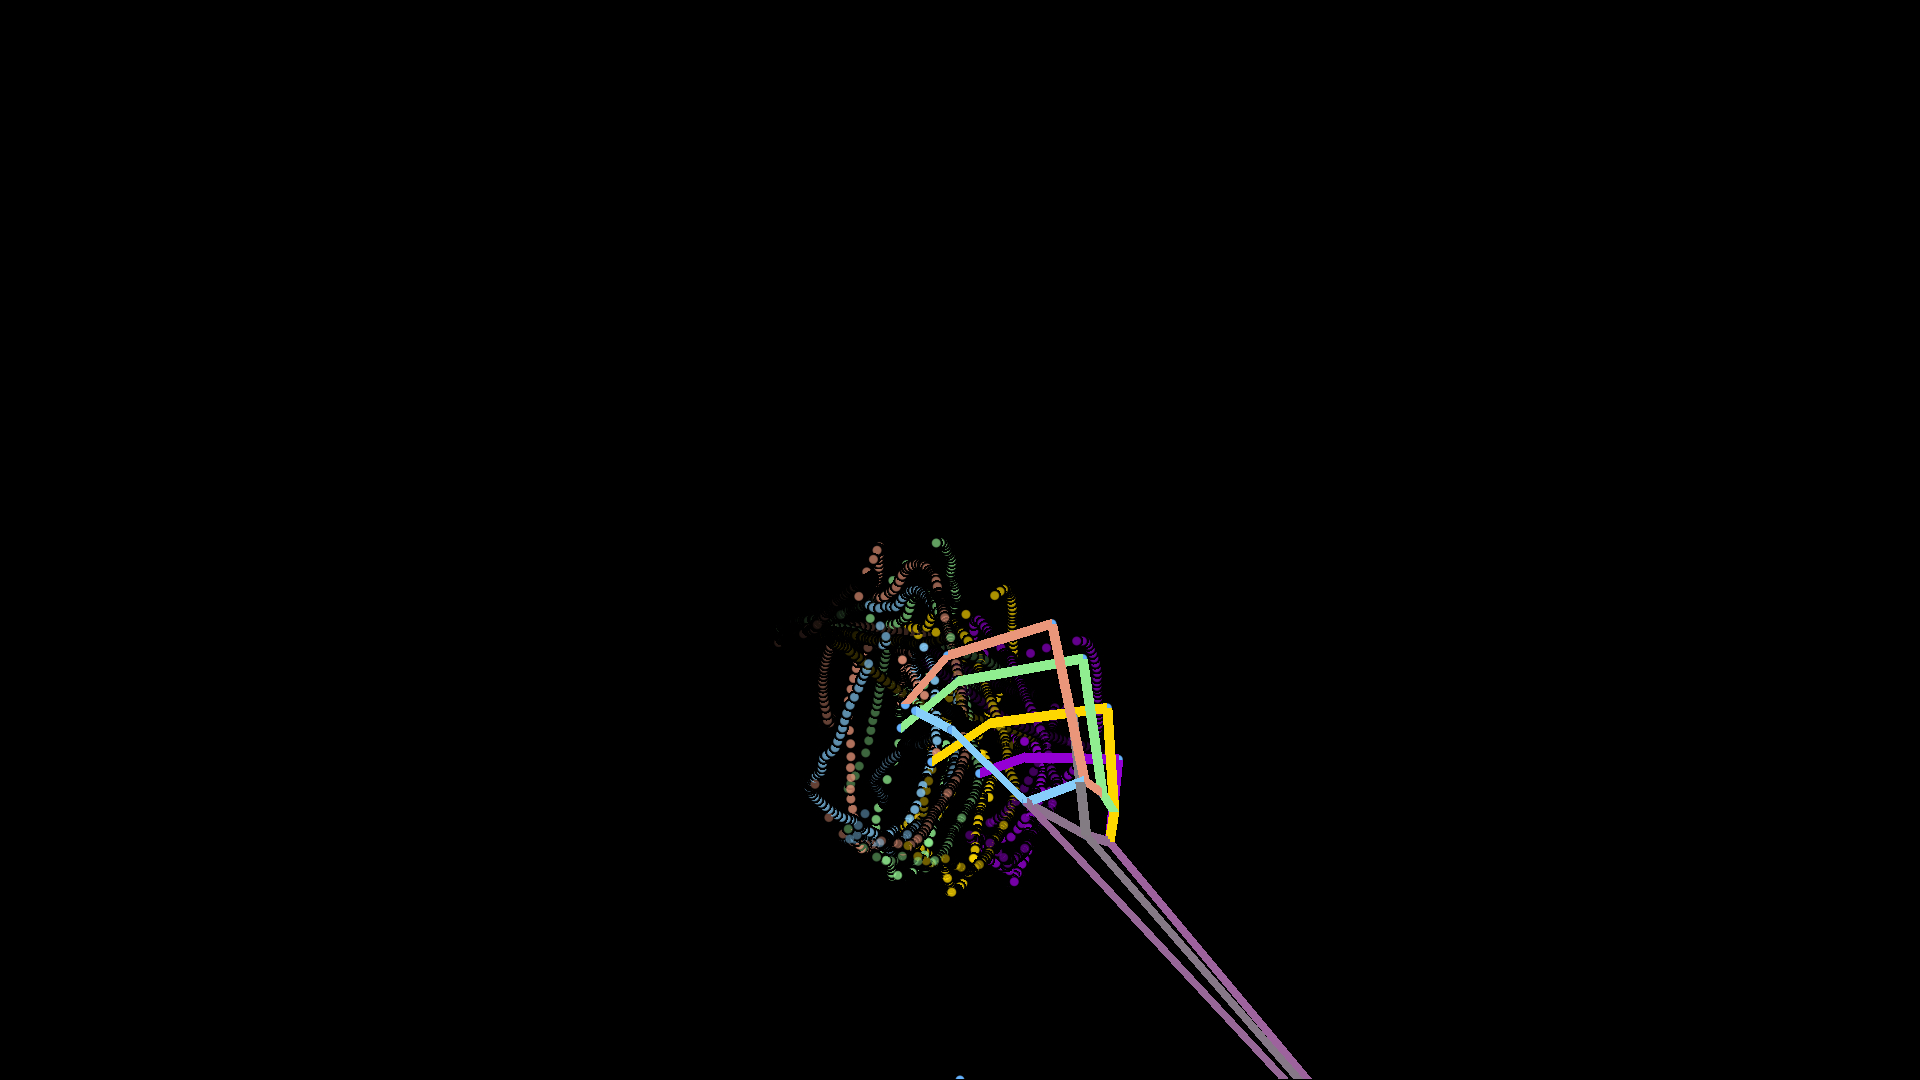

In [21]:
rnd_idx = np.random.randint(len(data.valid_dl.dl.dataset.x))
img   = data.valid_dl.dl.dataset.x[rnd_idx]
label = data.valid_dl.dl.dataset.y[rnd_idx]
print(label, img.size)
img

In [22]:
lr=1e-2

In [23]:
if runtime_name == 'colab':
    !bash -c 'if ! [ -d "/content/Ranger-Deep-Learning-Optimizer" ] ; then git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer ; cd Ranger-Deep-Learning-Optimizer ; ls -l ; pwd ; pip install -e . ; wget "https://raw.githubusercontent.com/lessw2020/Ranger-Mish-ImageWoof-5/master/ranger.py" ; else echo "/content/Ranger-Deep-Learning-Optimizer" already exists... ; fi'
!pip show ranger

Name: ranger
Version: 0.0.1
Summary: Ranger - a synergistic optimizer using RAdam (Rectified Adam) and LookAhead in one codebase 
Home-page: UNKNOWN
Author: Less Wright
Author-email: UNKNOWN
License: Apache
Location: /home/ranieri/Ranger-Deep-Learning-Optimizer
Requires: torch
Required-by: 


In [24]:
def show_hyperparams():
    print(f'Batch size: {bs}, image size: {img_size}, learning rate: {lr}')

In [25]:
def is_frozen(learn, debug=False):
    for child in learn.model.children():
        #print(child)
        for param in child.parameters():
            if debug:
                print(param.requires_grad)
            if param.requires_grad == False:
                return True, 'a'
    return False, 'b'

In [26]:
class SaveBestAccuracyCallback(TrackerCallback):
    "A `TrackerCallback` that stops the training when the accuracy reaches the desired level."
    def __init__(self, learn:Learner, save_str:str='best-accuracy-model'):
        super().__init__(learn, monitor='accuracy', mode='auto')
        self.prev_acc = 0.0
        self.save_str = save_str
    
    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Check the monitored value and save the model if above prev_acc."
        current = self.get_monitor_value()
        print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
        if current is not None and self.operator(current, self.prev_acc):
            print(f'Accuracy {current} is above previous accuracy {self.prev_acc} at epoch {epoch}. Saving model...')
            self.prev_acc = current
            self.learn.save(f'{self.save_str}-acc-{current}-epoch-{epoch}')

In [27]:
def do_fit_fc(save_name, epochs=10, lr=defaults.lr, start_pct=0.3):
    savepath.mkdir(exist_ok=True)
    
    save_str = str(savepath) + '/' + model_name + '-img_size-' + str(img_size) + '-' + save_name + '-' + currtime
    print(f'Learner object has path in: {learn.path} (which can be readonly, so we need to change it...)')
    learn.path = savepath
    print(f'Learner object new path is: {learn.path}')
    
    print(f'Saving models with prefix: {save_str}')
    
    reduce_lr_callback    = ReduceLROnPlateauCallback(learn, monitor='train_loss', patience=2, factor=0.2, min_delta=0)
    save_callback         = SaveModelCallback(learn, every='epoch', monitor='accuracy', name=save_str)
    #tracker_callback      = TrackerCallback(learn, monitor='feat_12')
    #stop_acc_callback     = StopAtThisAccuracyCallback(learn, value=0.999)
    save_best_callback    = SaveBestAccuracyCallback(learn, save_str=save_str)
    tensorboard           = None
    if tensorboard:
        tboard_callback   = LearnerTensorboardWriter(learn, base_dir=tboard_path, name=save_str)
    else:
        tboard_callback   = None

    #callbacks             = [save_callback, reduce_lr_callback, stop_acc_callback, save_best_callback, tboard_callback]
    callbacks             = [save_callback, reduce_lr_callback]
    
    learn.fit_fc(epochs, lr, start_pct=start_pct, callbacks=callbacks)
    learn.save(save_str)
    
    print('nvidia-smi memory usage/increment:', nvidia_smi(nvidia_smi_, gpu_num=cuda_training_device))
    learn.show_results(rows=3)

# Fast.ai doesn't provide an `evaluate()`-like function as in Keras

![alt text](https://i.ibb.co/86k8rFN/image.png)

So it's not possible to have a labeled test set in the same databunch used for training/validation of the model. Ok, let's follow the advice and build another databunch with training and test set (used as validation set). <spoiler> In Keras there's a handy [model.evaluate()](https://keras.io/models/model/#evaluate) function to test the model. </spoiler>

In [28]:
def evaluate_model_from_interp(interp, data):
  # perform a "manual" evaluation of the model to take a look at predictions vs. labels and to
  # re-compute accuracy from scratch (to double check and also because I didn't find a quick way
  # to extract accuracy inside the guts of Fast.ai after a call to validate() on the test set...)
  print(f'Interp has {len(interp.y_true)} ground truth labels: {interp.y_true}')
  print(f'Interp yielded {len(interp.preds)} raw predictions. First two raw predictions are: {interp.preds[:2]}')
  print(f'The problem had {len(data.classes)} classes: {data.classes}') # data.c is just len(data.classes)

  print('')
  print(f'Pred -> GroundTruth = PredLabel -> GroundTruthLabel')

  ok_pred = 0

  for idx, raw_p in enumerate(interp.preds):
      pred = np.argmax(raw_p)
      if idx < 100000:
          print(f'{pred} -> {interp.y_true[idx]} = {data.classes[pred]} -> {data.valid_ds.y[idx]}')
      if pred == interp.y_true[idx]:
          ok_pred += 1

  acc = ok_pred / len(interp.y_true)
  print(f'Overall accuracy of the model: {acc:0.5f}')
  return acc

# Training

### Round 1 - 112px

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


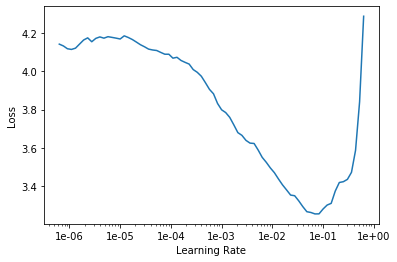

In [29]:
learn.lr_find()
learn.recorder.plot()

In [30]:
show_hyperparams()

Batch size: 64, image size: 112, learning rate: 0.01


In [31]:
train_round=1
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-112-1a-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [2872, 2785]


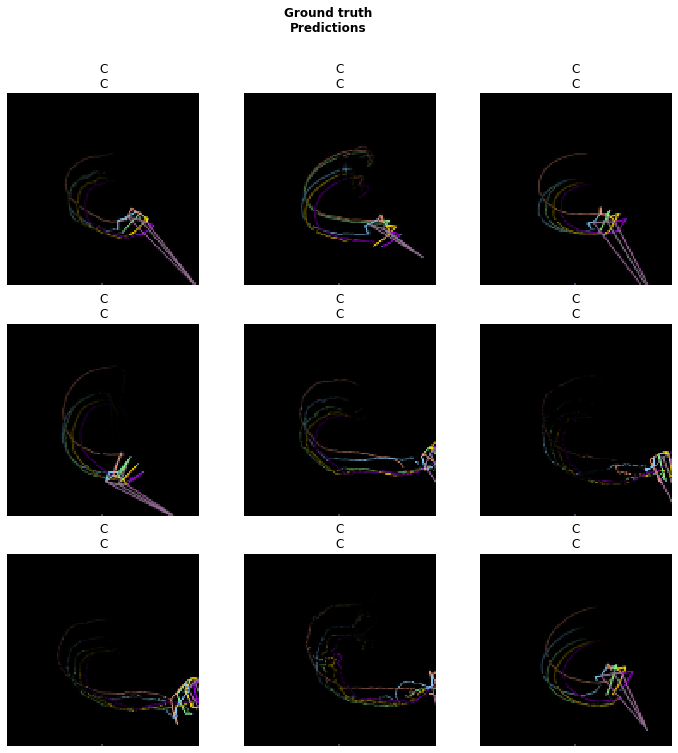

In [32]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [33]:
train_round=1
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


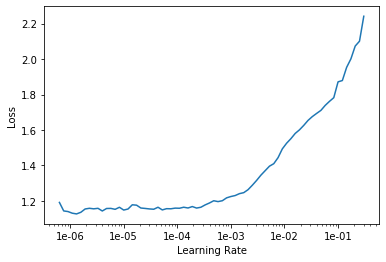

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
lr=1e-4

Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-112-1b-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [3174, 389]


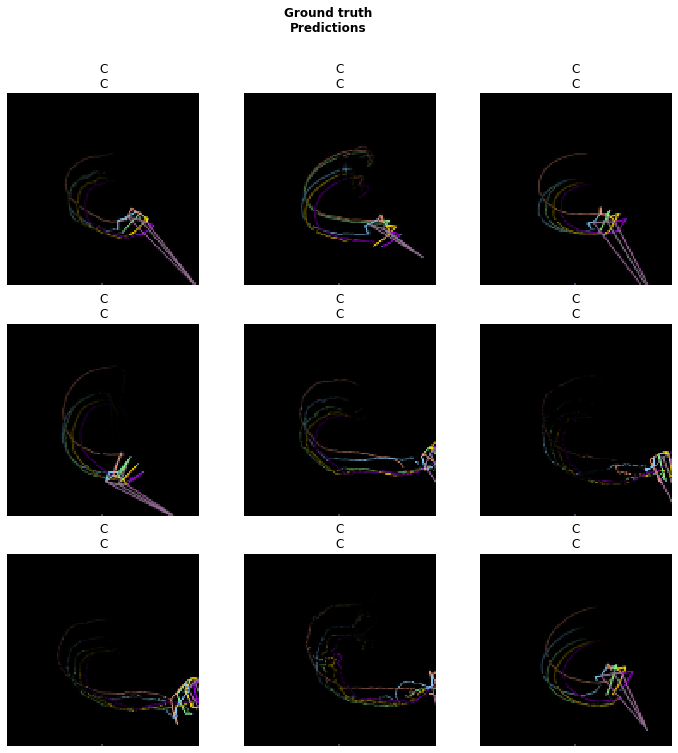

In [36]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

Interpreting results and plotting top losses for stage-1


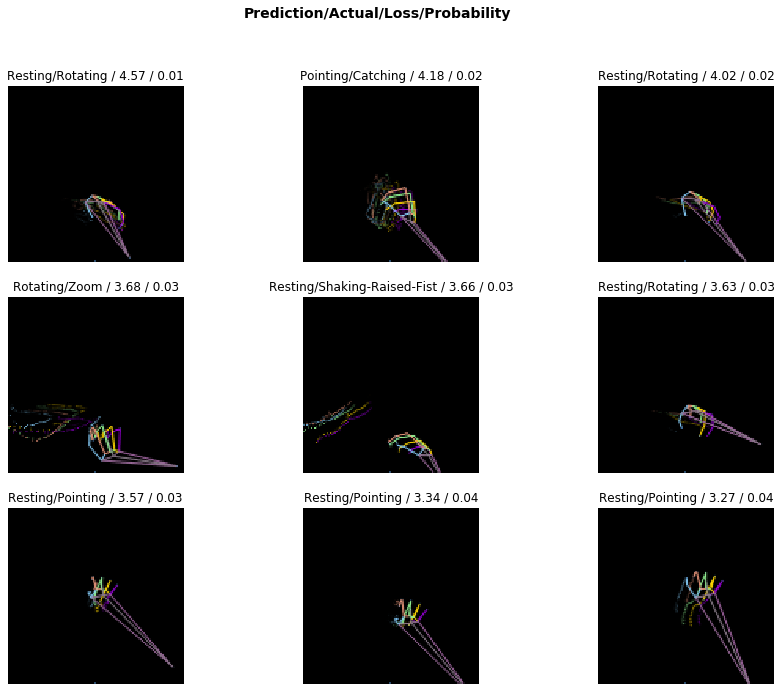

In [37]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-1


[('Pointing', 'Resting', 7),
 ('Rotating', 'Resting', 4),
 ('Resting', 'Pointing', 3),
 ('Shaking', 'Shaking-Raised-Fist', 2)]

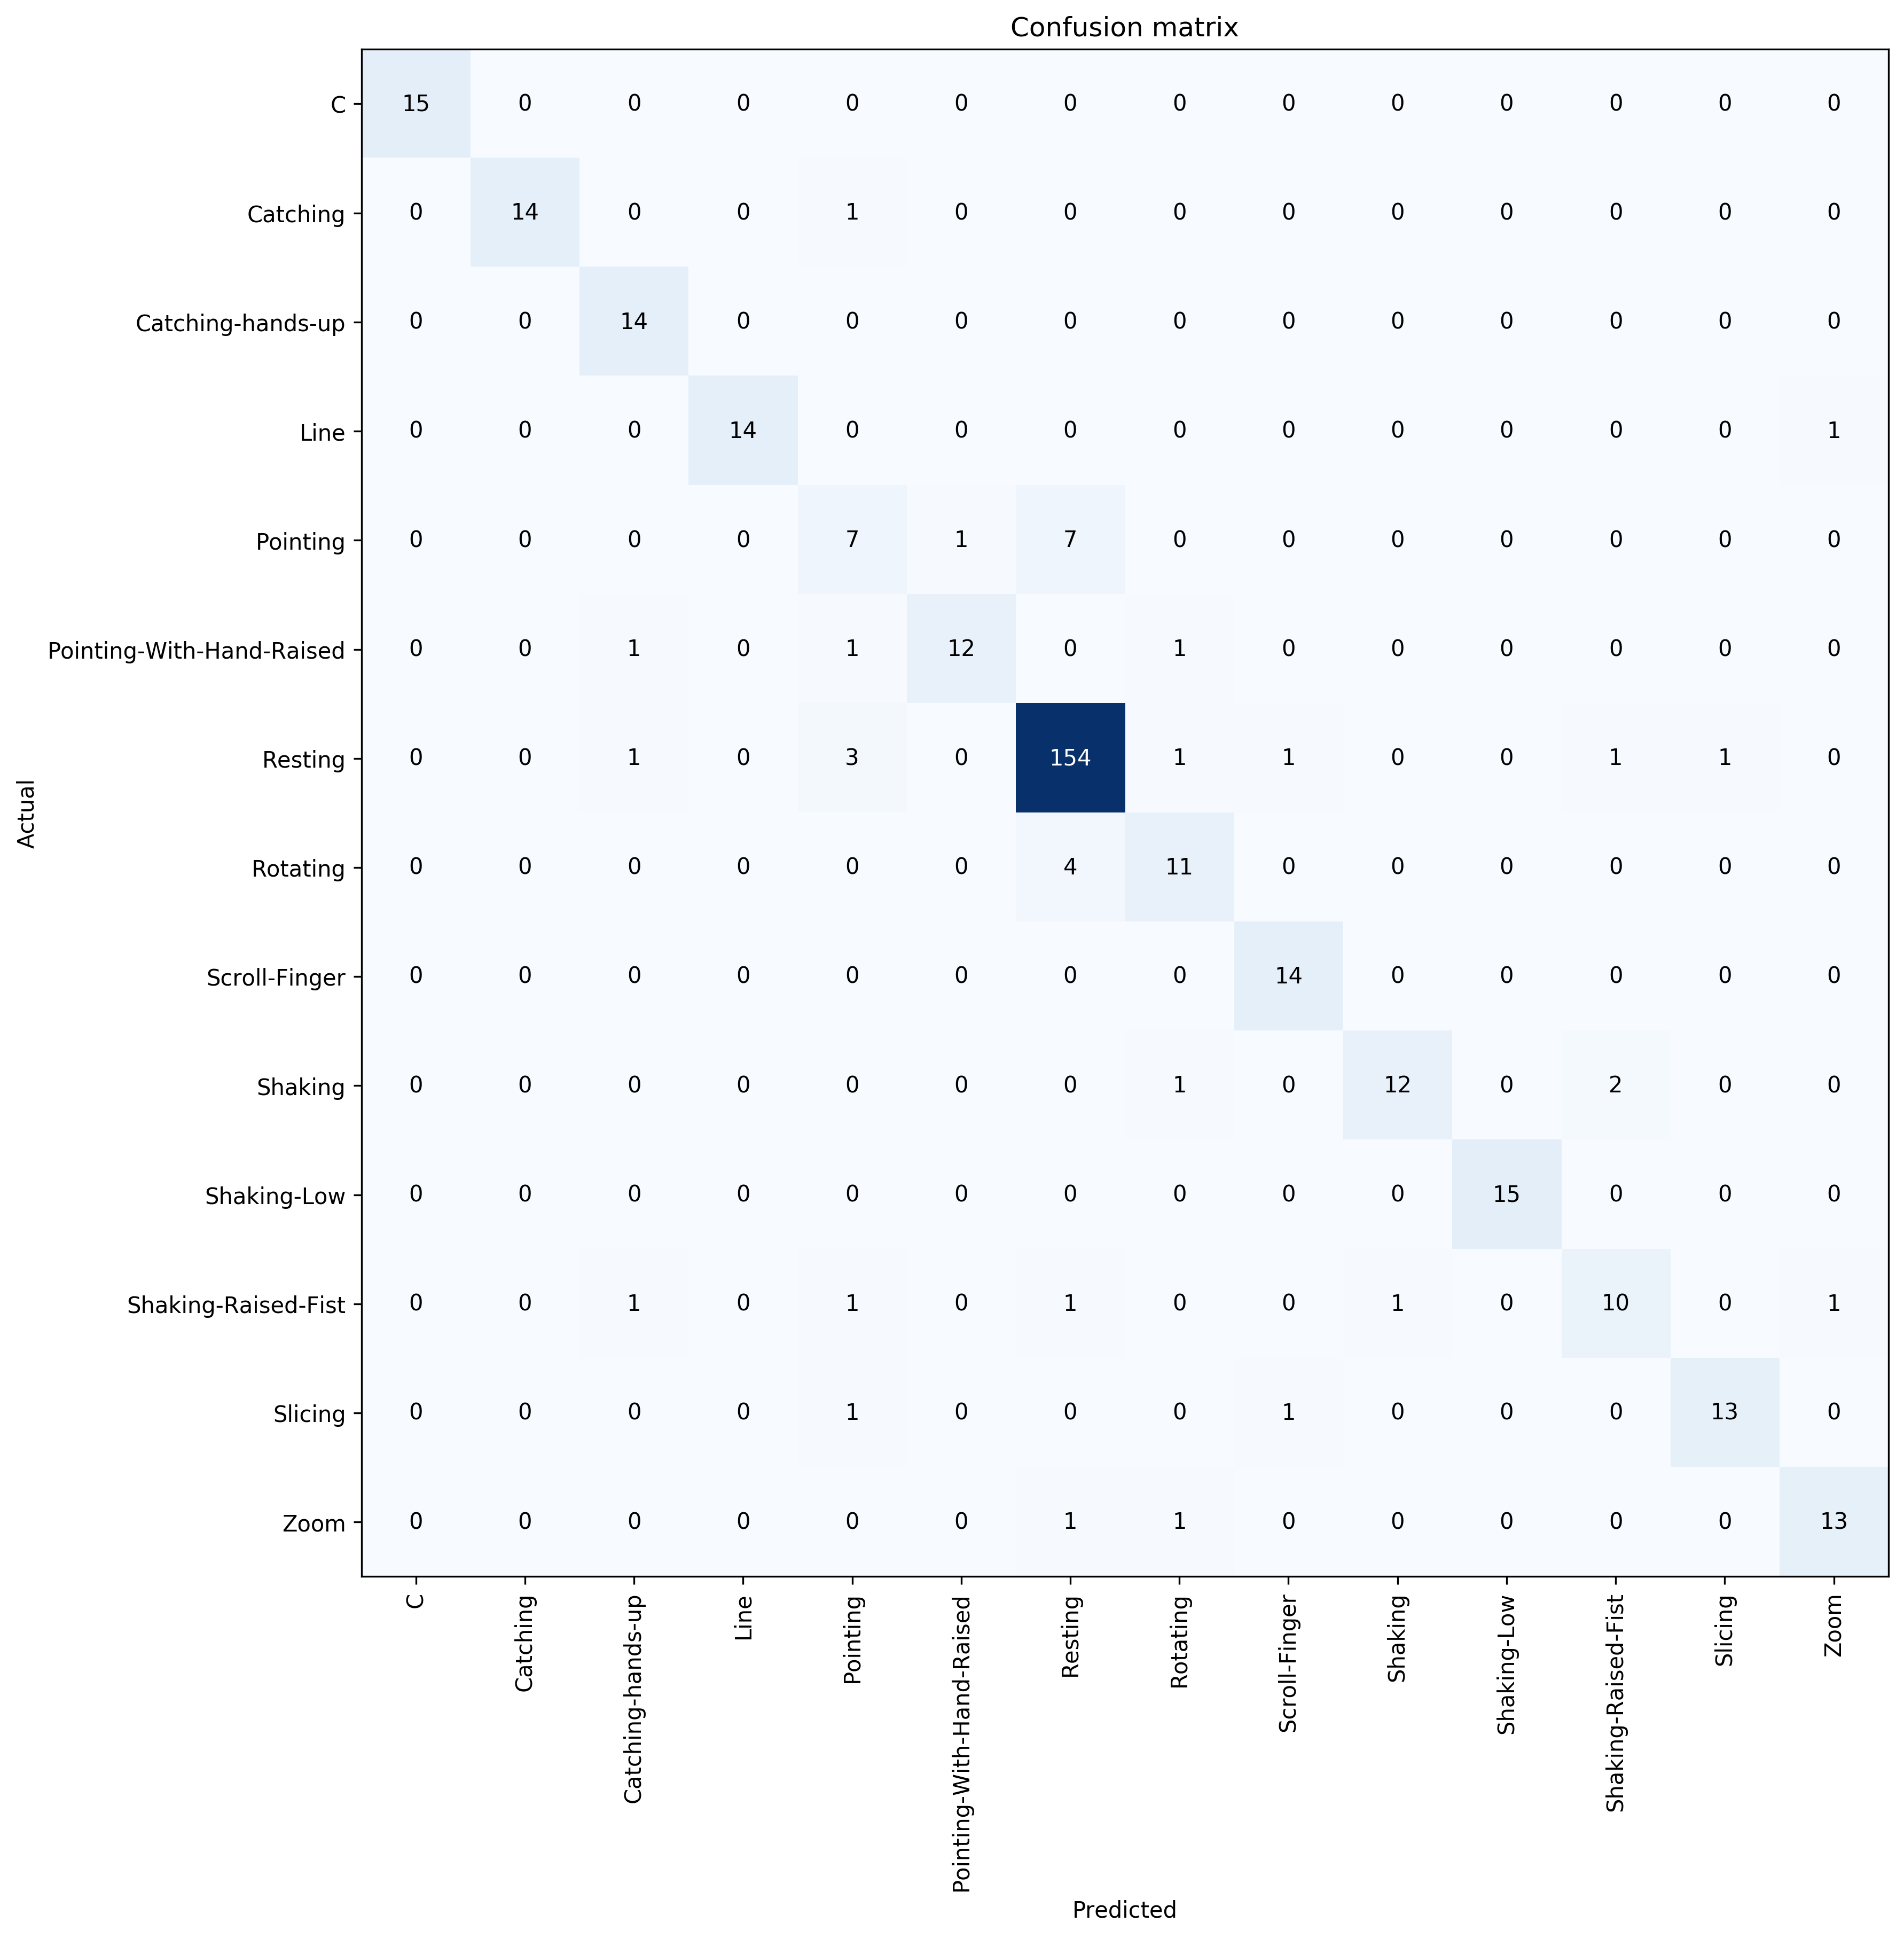

In [43]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-1


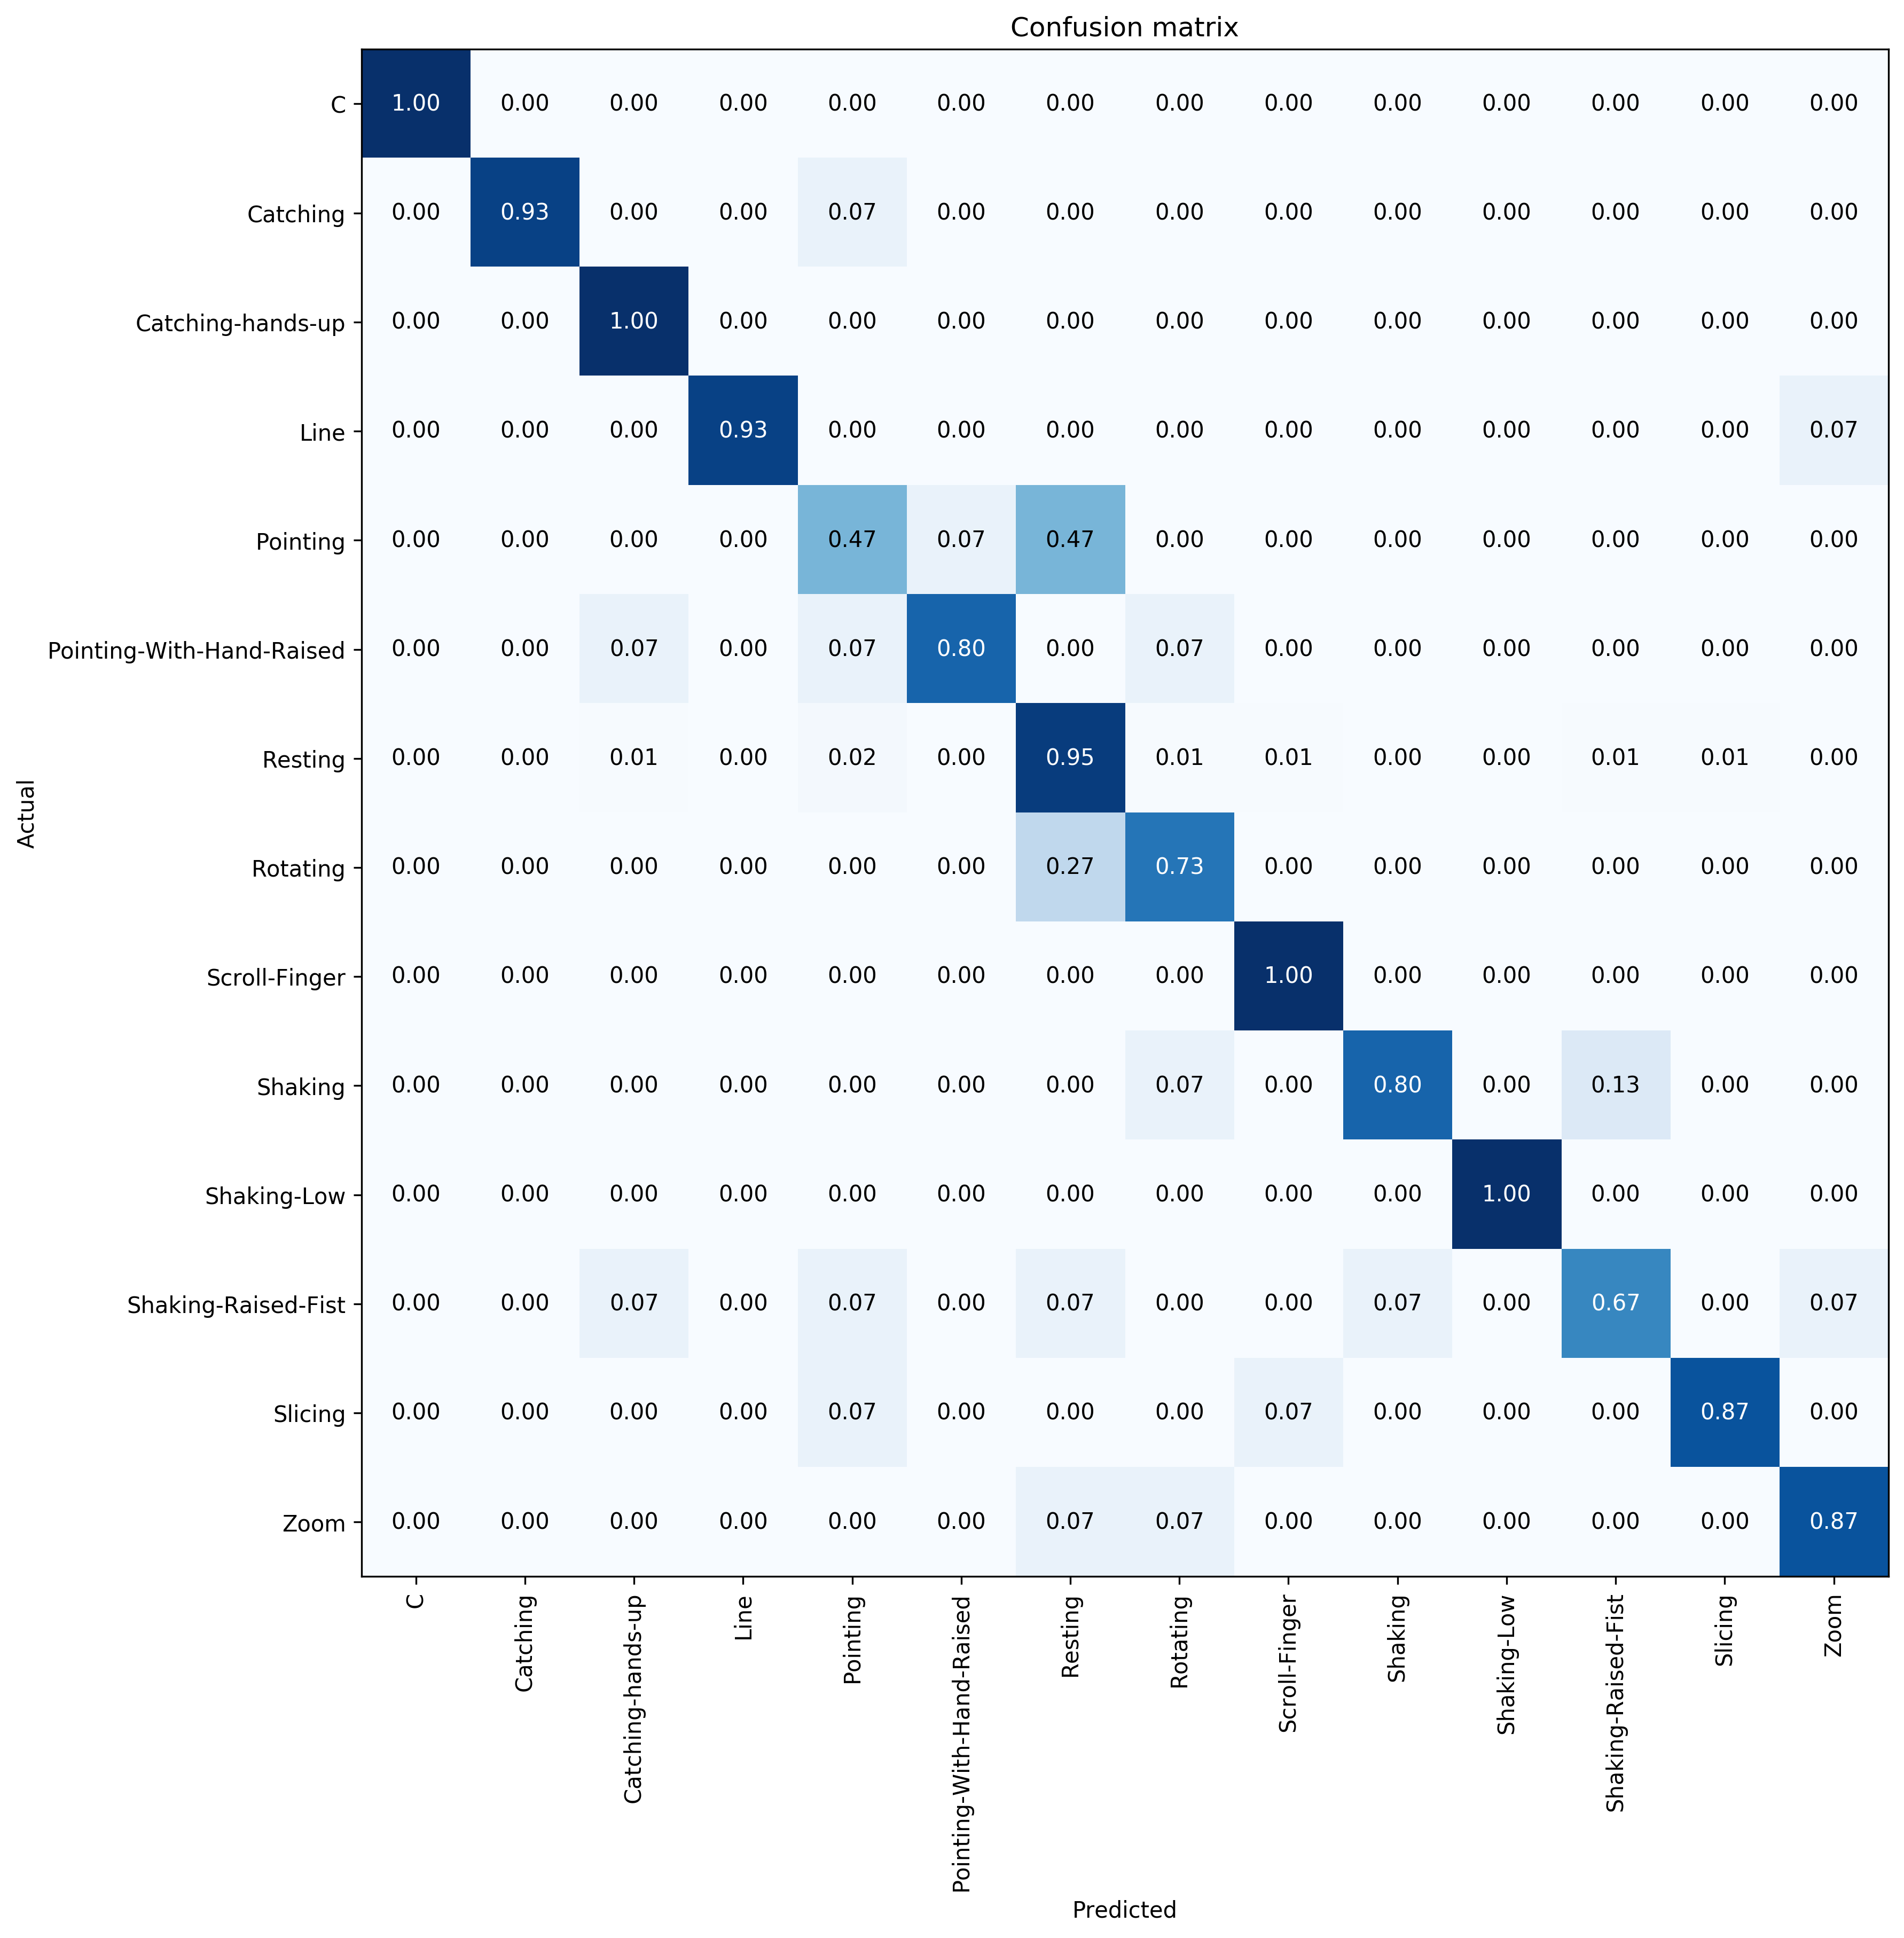

In [42]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

In [39]:
acc = evaluate_model_from_interp(interp, data)

Interp has 355 ground truth labels: tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
    

### Round 2 - 224px

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 779, y: 779)
Validation set len is: (x: 355, y: 355)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


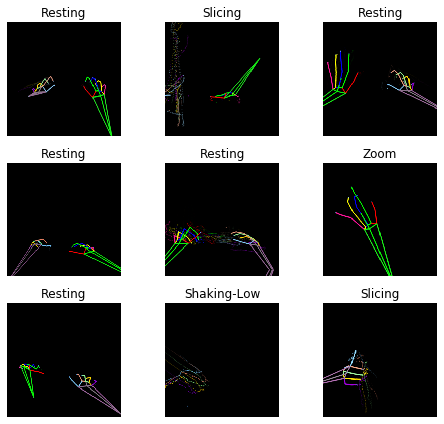

In [44]:
bs=64
img_size=224
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([64, 3, 224, 224])
Image  shape: torch.Size([3, 224, 224])
Labels shape: torch.Size([64])
Label[0]: 6 -> Resting
Label[2]: 9


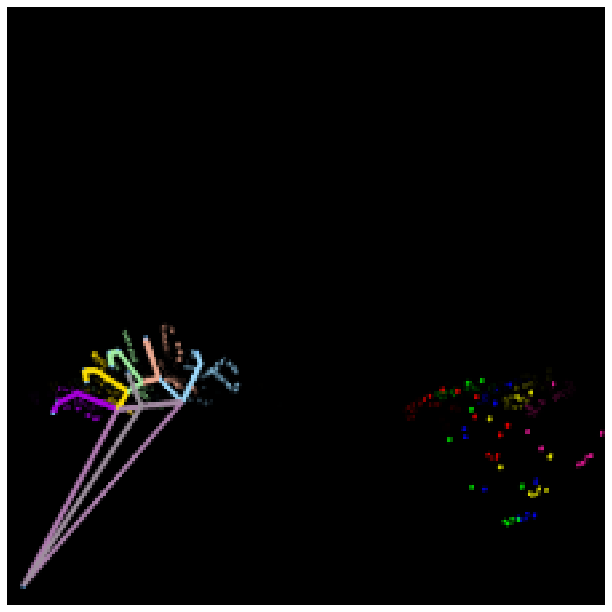

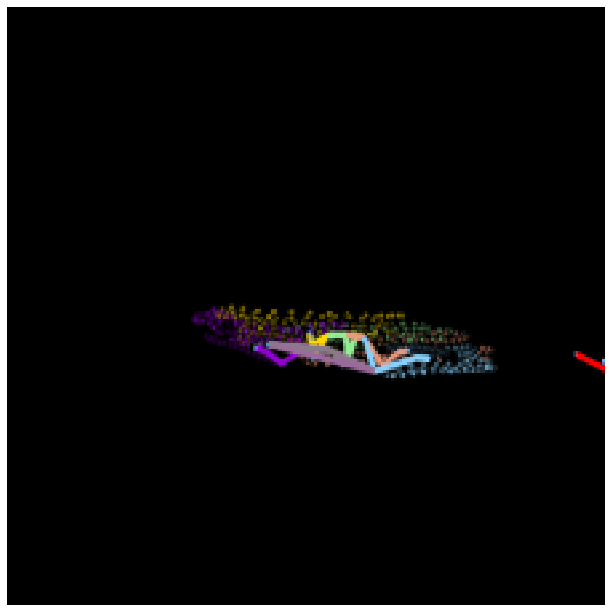

In [45]:
show_augmented_images()

In [46]:
show_hyperparams()

Batch size: 64, image size: 224, learning rate: 0.0001


In [47]:
train_round=2
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


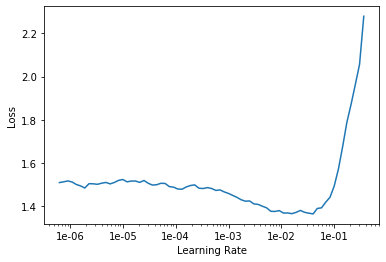

In [48]:
learn.lr_find()
learn.recorder.plot()

In [49]:
lr=5*1e-3

Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-224-2a-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [7530, 7141]


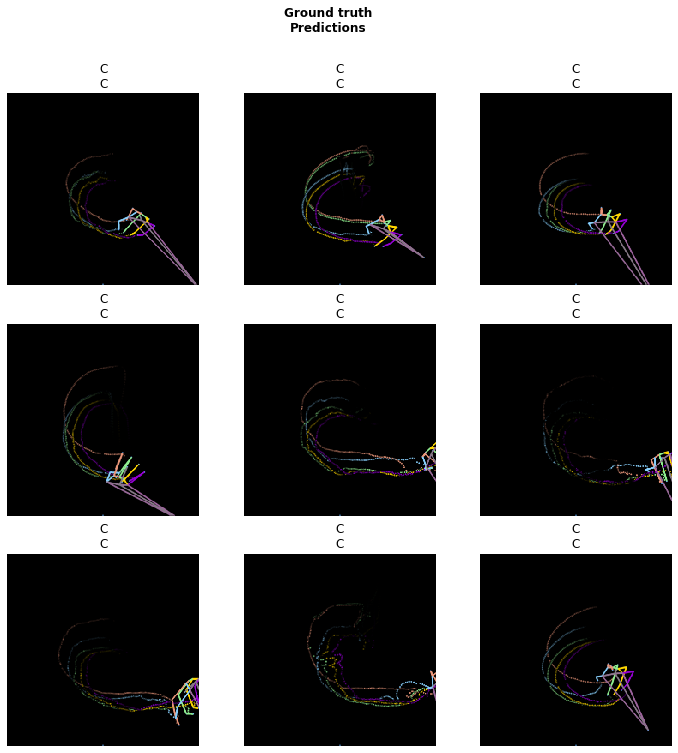

In [50]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [51]:
train_round=2
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


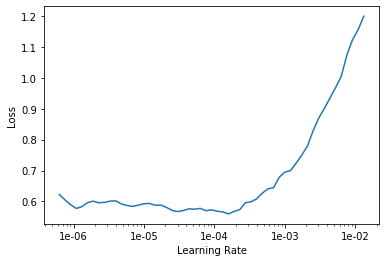

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
lr=1e-4

In [54]:
show_hyperparams()

Batch size: 64, image size: 224, learning rate: 0.0001


Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-224-2b-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [7706, 565]


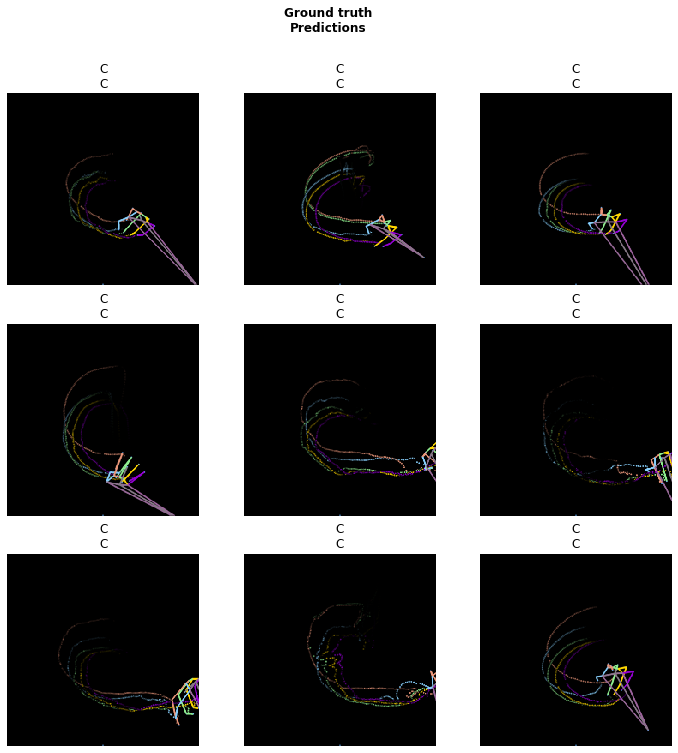

In [55]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

### Round 3 - 336px

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 779, y: 779)
Validation set len is: (x: 355, y: 355)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


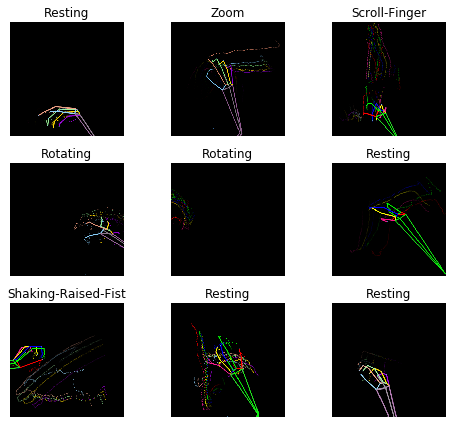

In [56]:
bs=64
img_size=336
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([64, 3, 336, 336])
Image  shape: torch.Size([3, 336, 336])
Labels shape: torch.Size([64])
Label[0]: 9 -> Shaking
Label[2]: 7


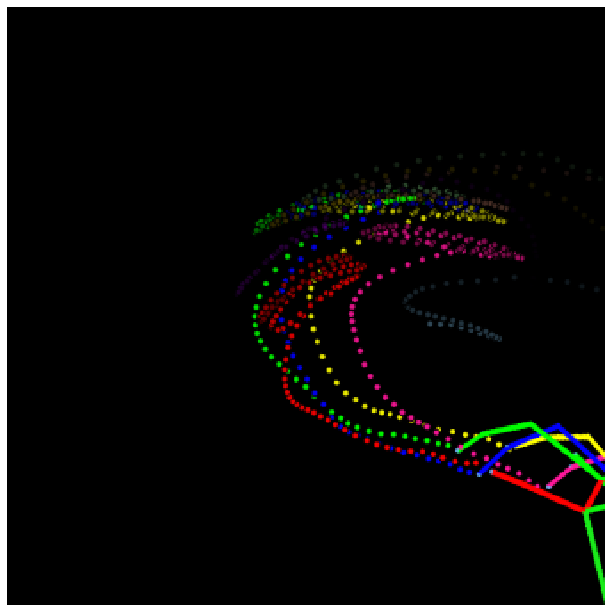

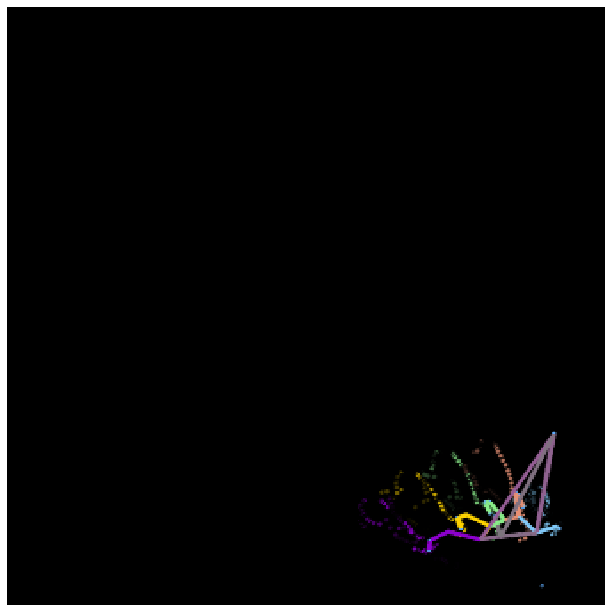

In [57]:
show_augmented_images()

In [58]:
show_hyperparams()

Batch size: 64, image size: 336, learning rate: 0.0001


In [59]:
train_round=3
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


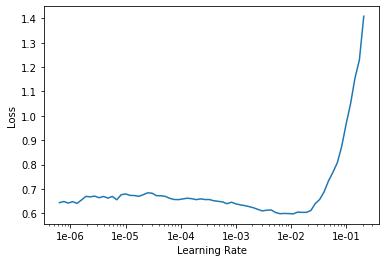

In [60]:
learn.lr_find()
learn.recorder.plot()

In [61]:
lr=1e-2

Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-336-3a-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [15742, 15177]


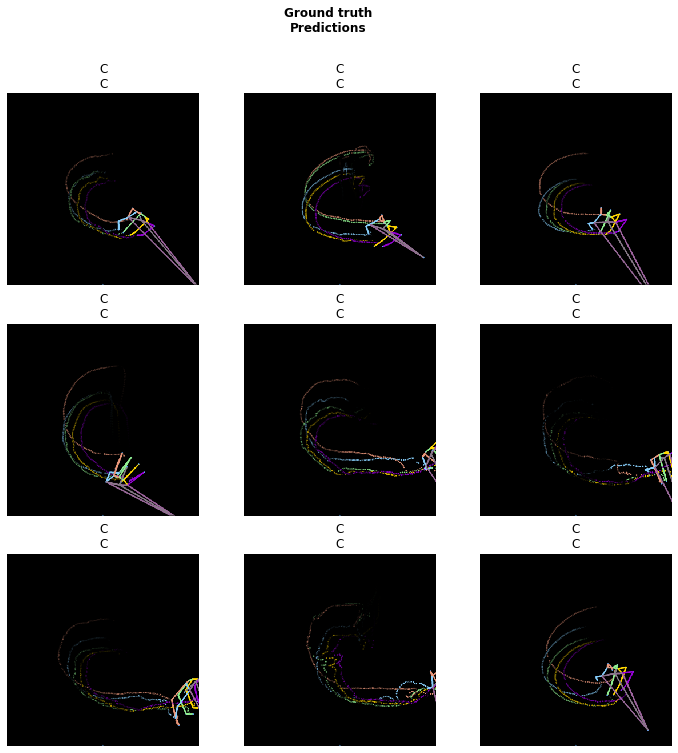

In [62]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [63]:
train_round=3
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


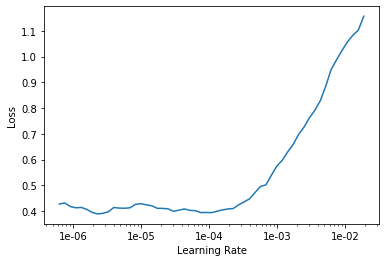

In [64]:
learn.lr_find()
learn.recorder.plot()

In [65]:
lr=1e-4

In [66]:
show_hyperparams()

Batch size: 64, image size: 336, learning rate: 0.0001


Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-336-3b-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [15892, 715]


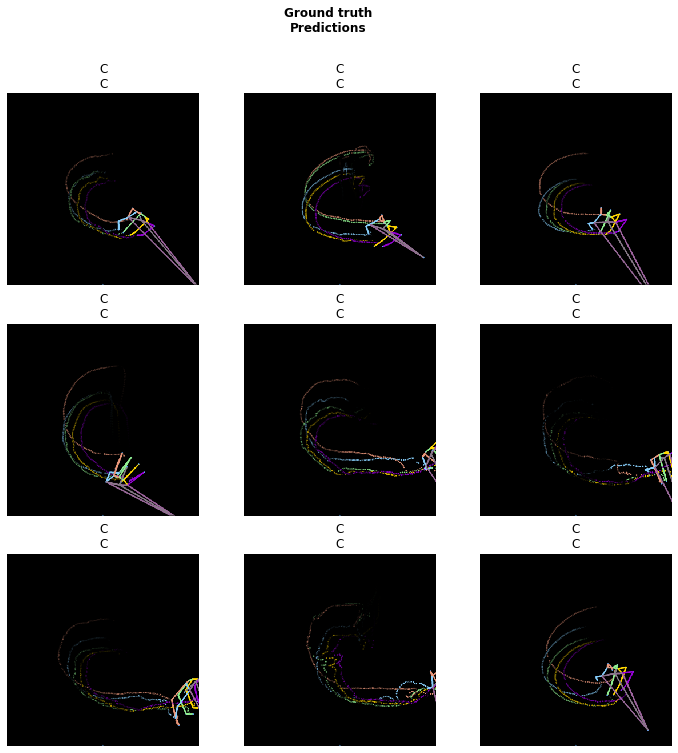

In [67]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

### Round 4 - 540px

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 779, y: 779)
Validation set len is: (x: 355, y: 355)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


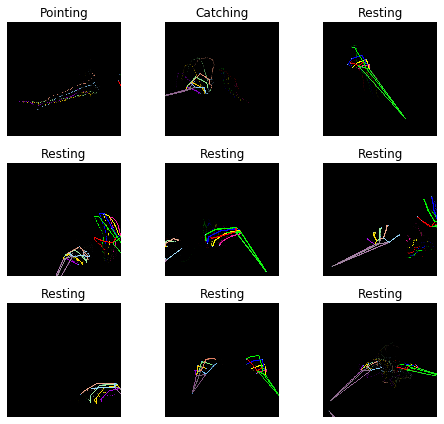

In [68]:
bs=16
img_size=540
data = create_dataset(bs, img_size)
learn.data = data

Batch  shape: torch.Size([16, 3, 540, 540])
Image  shape: torch.Size([3, 540, 540])
Labels shape: torch.Size([16])
Label[0]: 7 -> Rotating
Label[2]: 6


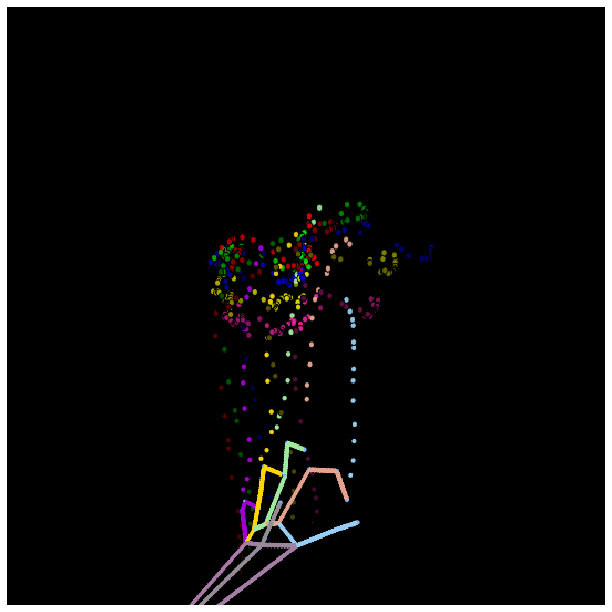

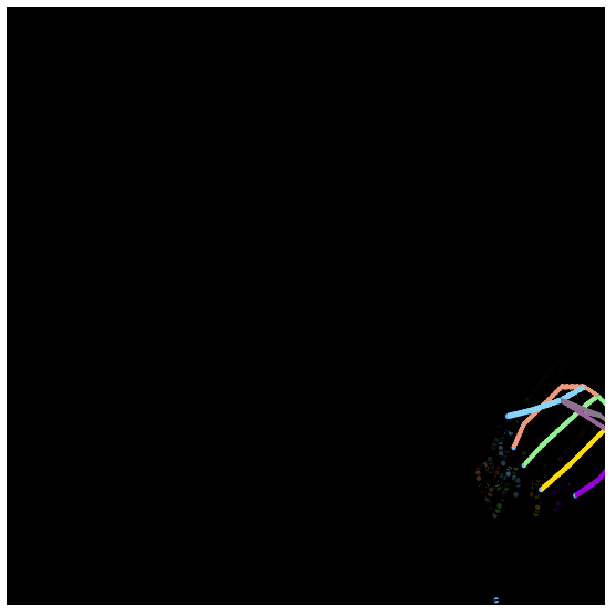

In [69]:
show_augmented_images()

In [70]:
show_hyperparams()

Batch size: 16, image size: 540, learning rate: 0.0001


In [71]:
train_round=4
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


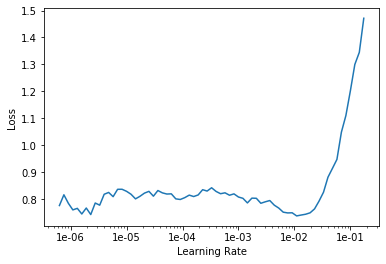

In [72]:
learn.lr_find()
learn.recorder.plot()

In [73]:
lr=1e-2

Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-540-4a-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [10694, 9979]


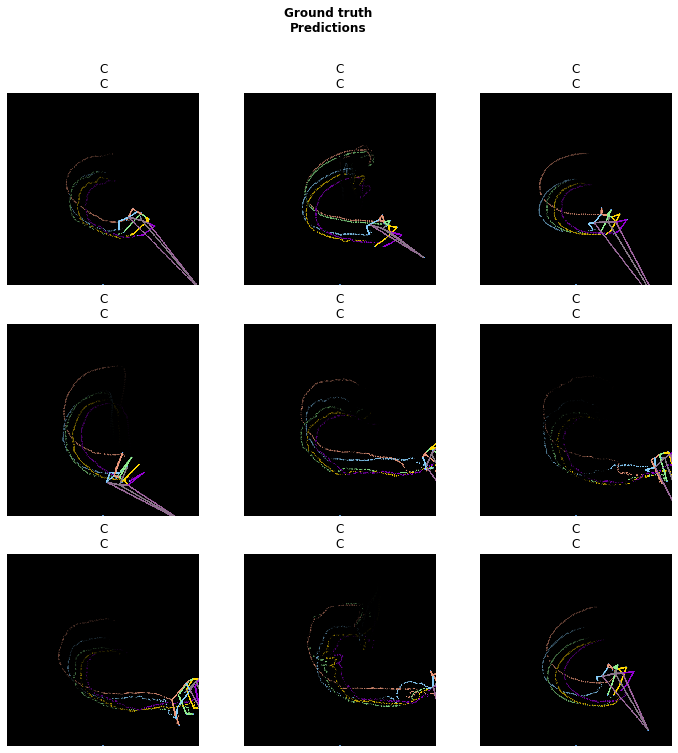

In [74]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [75]:
train_round=4
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


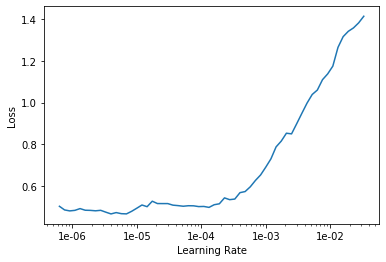

In [76]:
learn.lr_find()
learn.recorder.plot()

In [77]:
lr=1e-4

In [78]:
show_hyperparams()

Batch size: 16, image size: 540, learning rate: 0.0001


Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-540-4b-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [10890, 911]


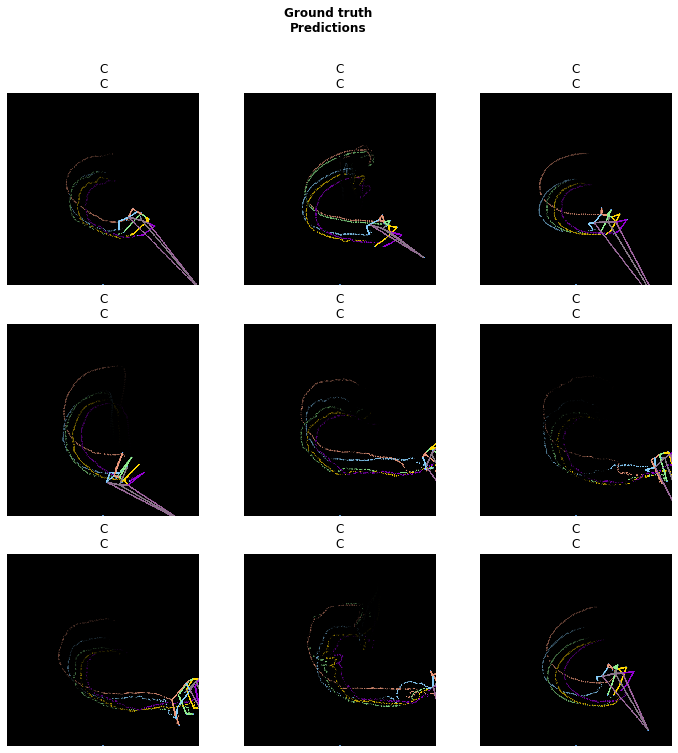

In [79]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

### Round 5 - 810px

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 779, y: 779)
Validation set len is: (x: 355, y: 355)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


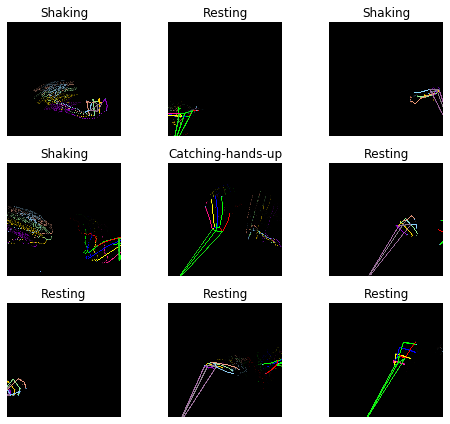

In [80]:
bs=16
img_size=810
data = create_dataset(bs, img_size)
learn.data = data

In [81]:
train_round=5
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


Batch  shape: torch.Size([16, 3, 810, 810])
Image  shape: torch.Size([3, 810, 810])
Labels shape: torch.Size([16])
Label[0]: 6 -> Resting
Label[2]: 6


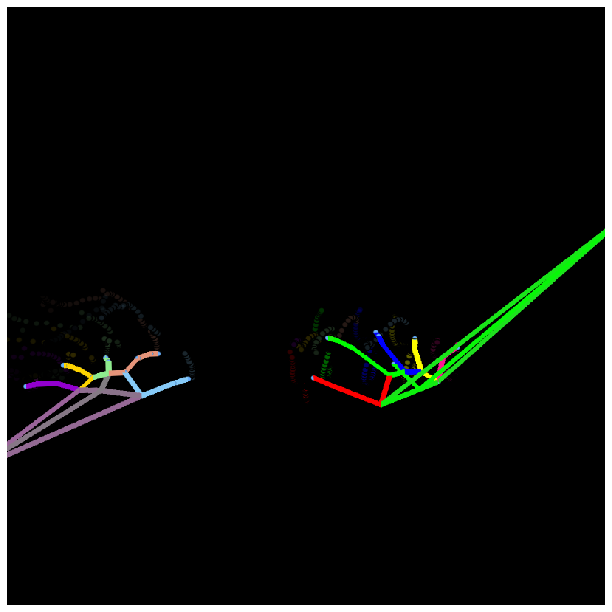

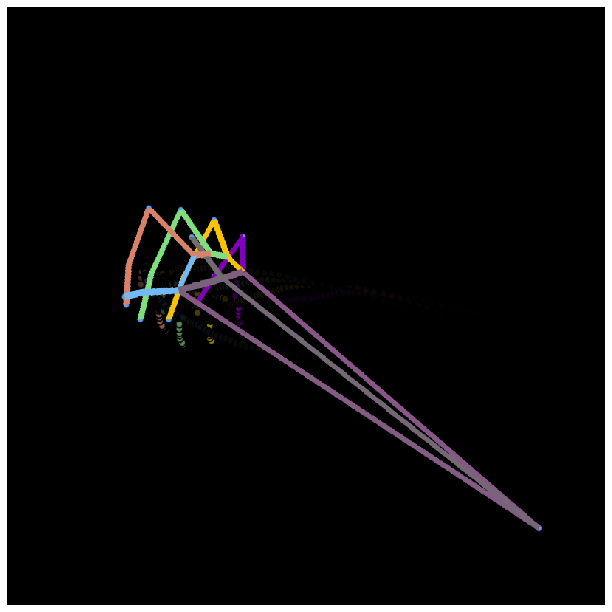

In [82]:
show_augmented_images()

In [83]:
show_hyperparams()

Batch size: 16, image size: 810, learning rate: 0.0001


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


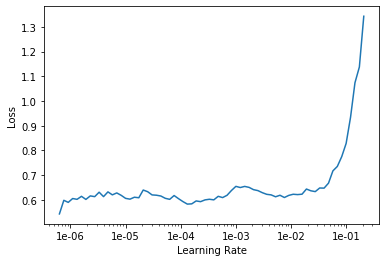

In [84]:
learn.lr_find()
learn.recorder.plot()

In [85]:
lr=1e-2

Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-810-5a-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [22608, 21697]


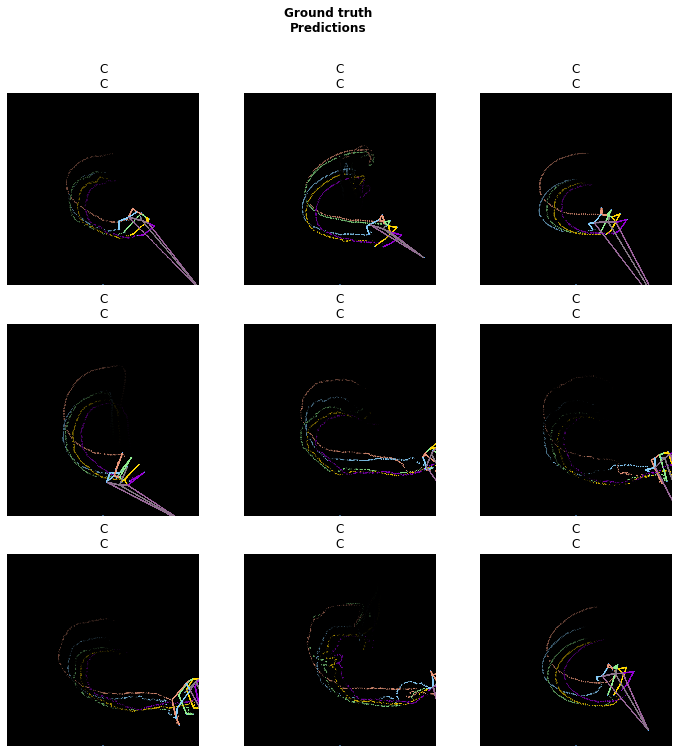

In [86]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [87]:
train_round=5
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


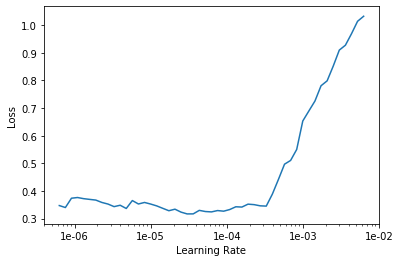

In [88]:
learn.lr_find()
learn.recorder.plot()

In [89]:
lr=1e-4

In [90]:
show_hyperparams()

Batch size: 16, image size: 810, learning rate: 0.0001


Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-810-5b-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [22746, 1049]


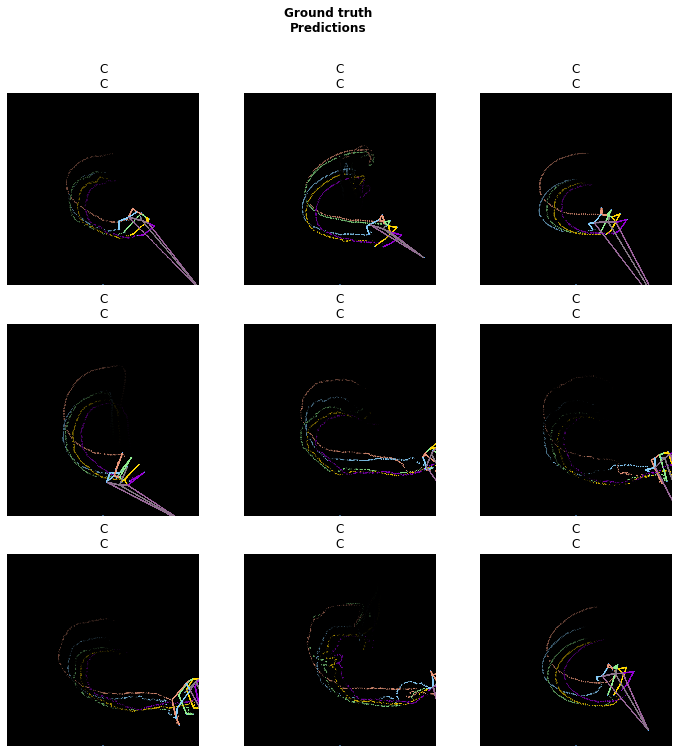

In [91]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

Interpreting results and plotting top losses for stage-5


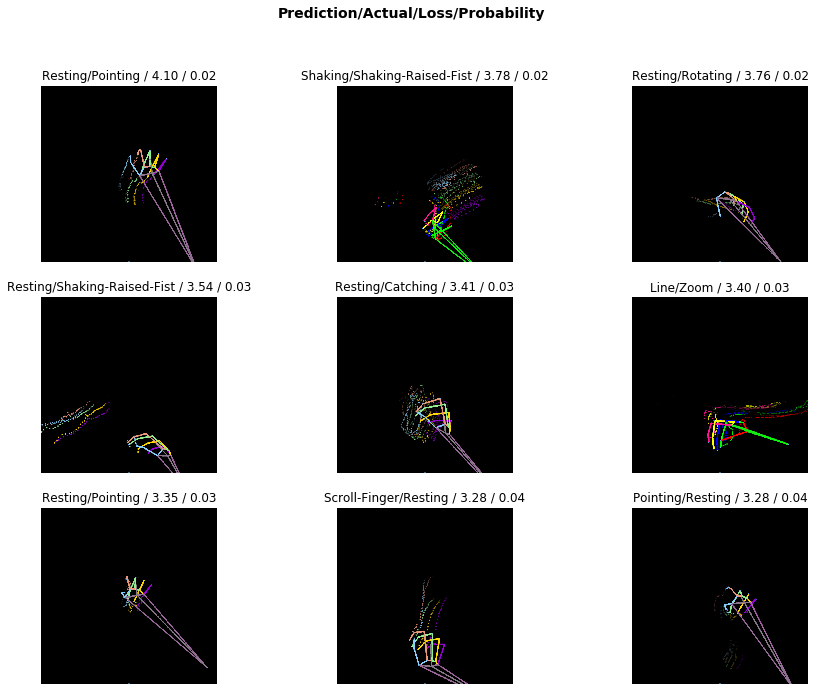

In [92]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-5


[('Resting', 'Pointing', 6),
 ('Pointing-With-Hand-Raised', 'Pointing', 4),
 ('Rotating', 'Resting', 4),
 ('Pointing', 'Resting', 3),
 ('Resting', 'Scroll-Finger', 2),
 ('Resting', 'Slicing', 2)]

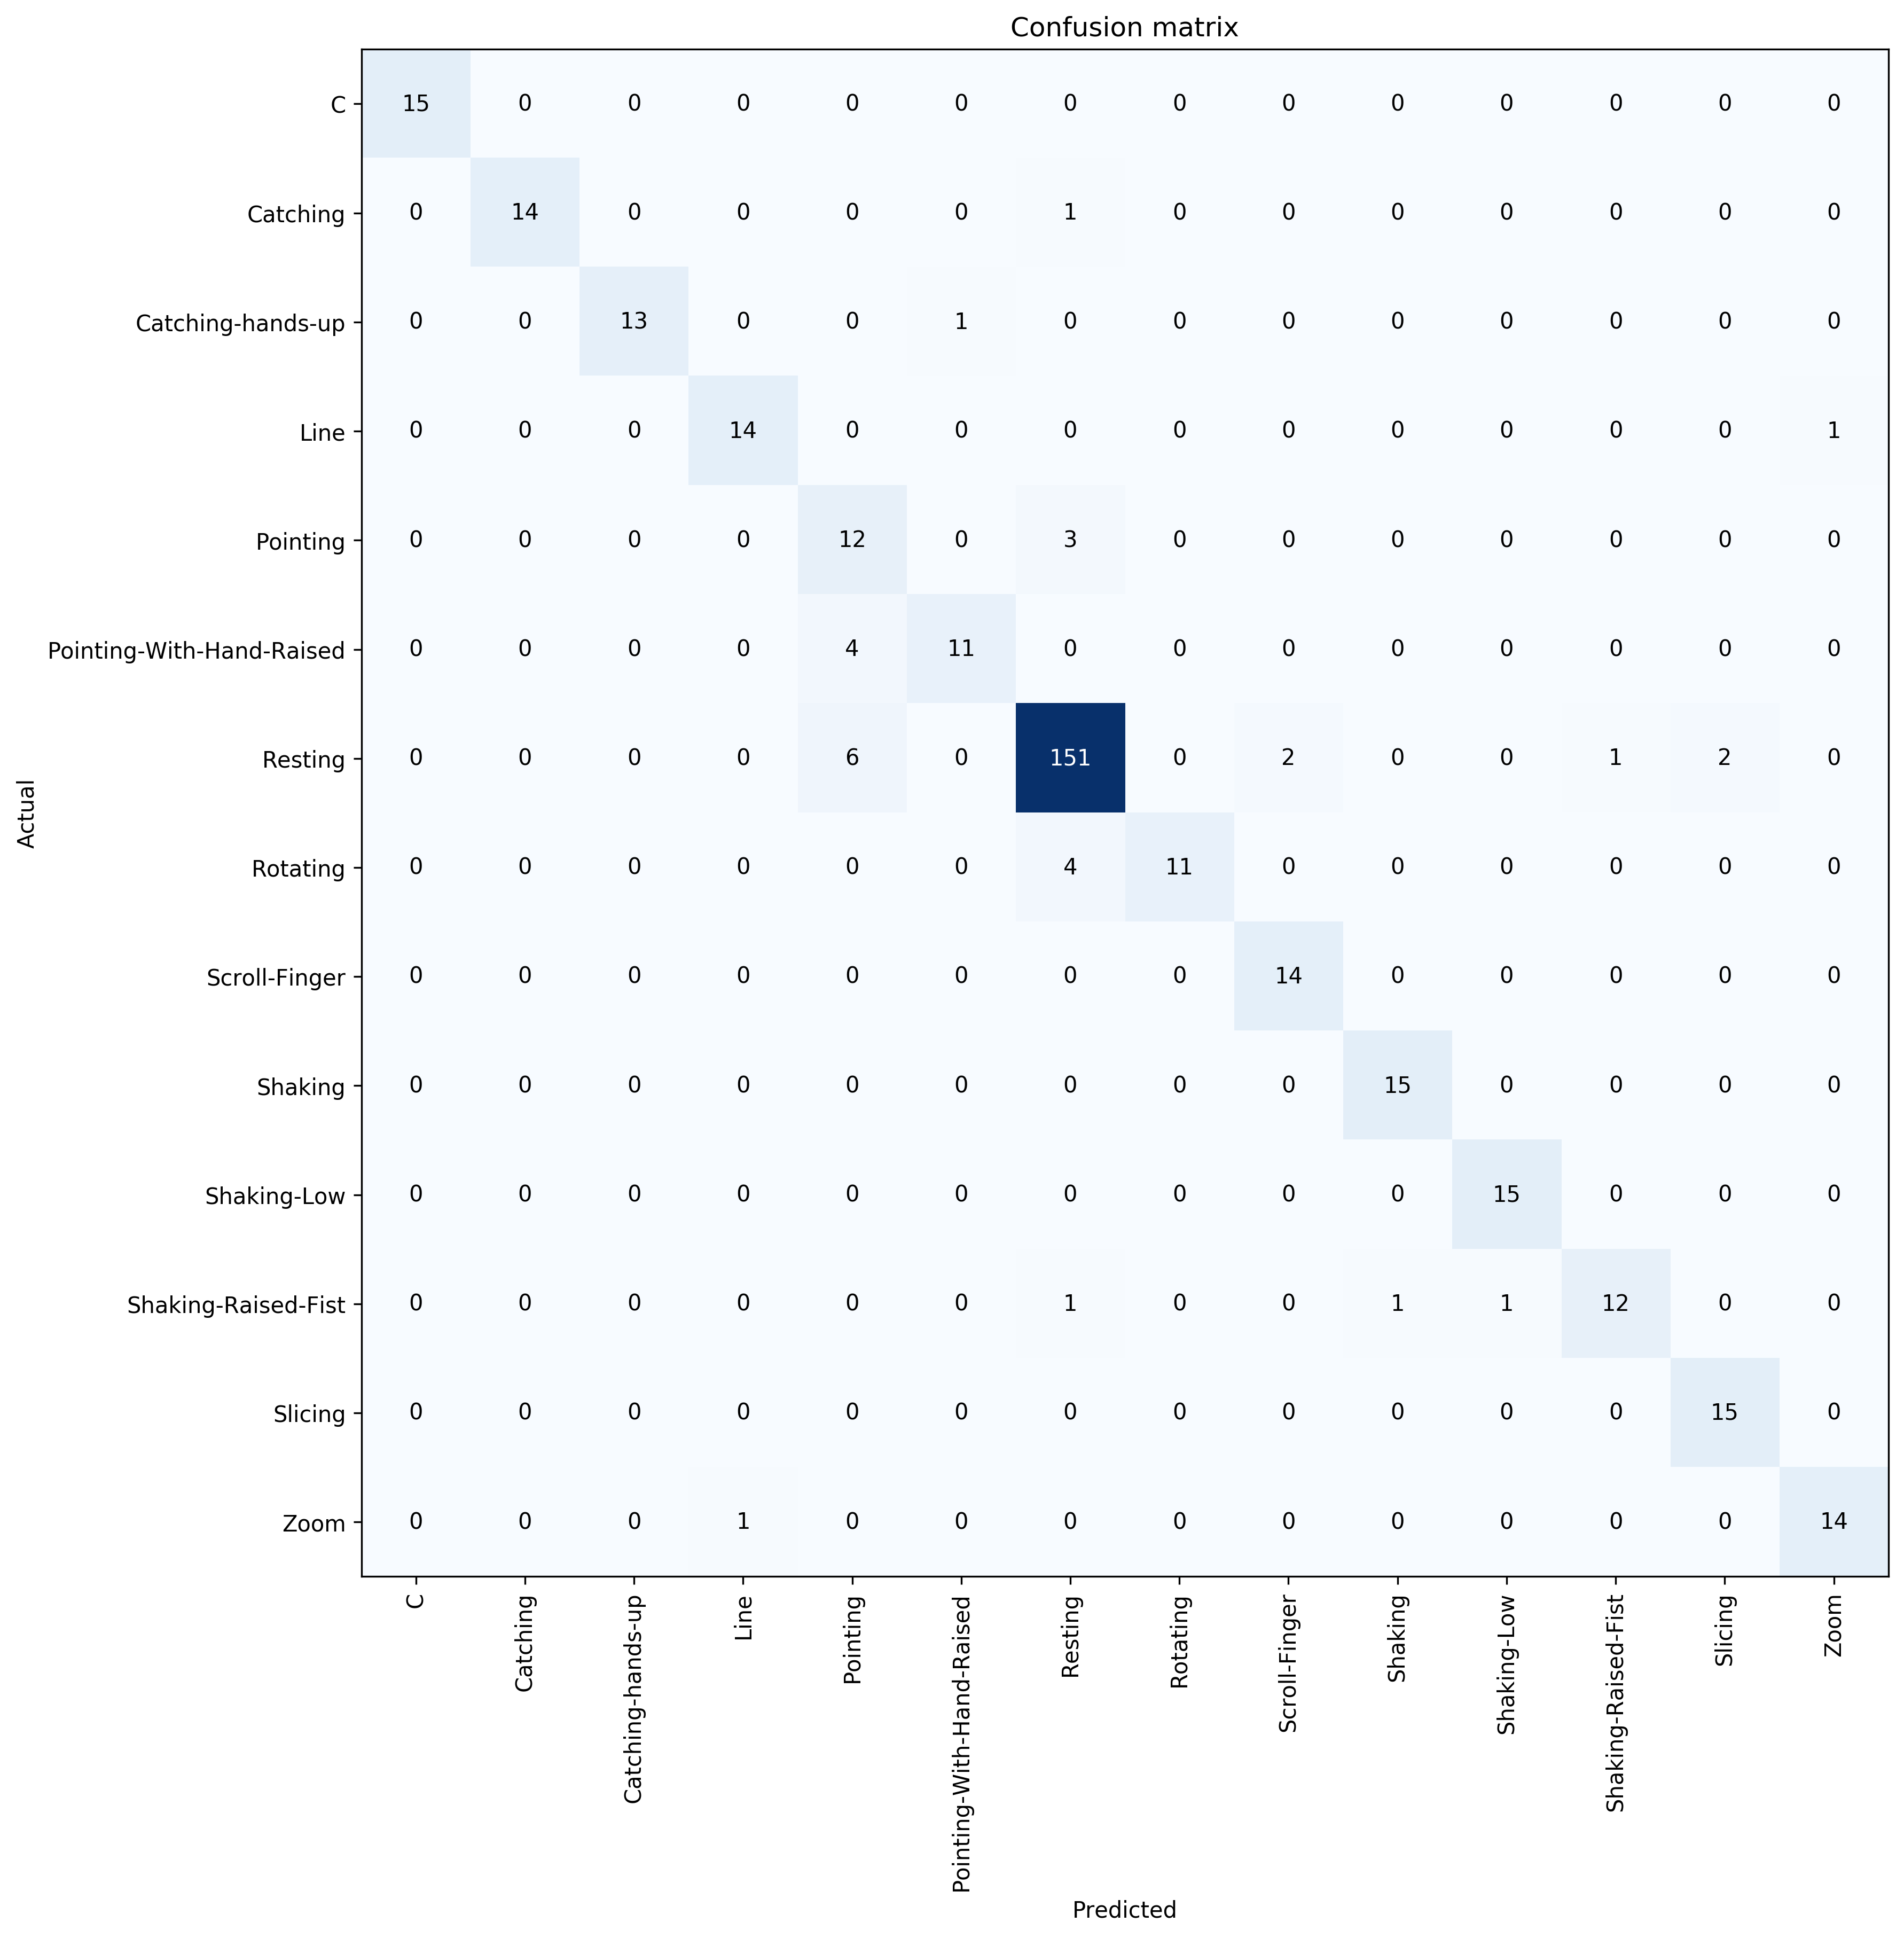

In [93]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-5


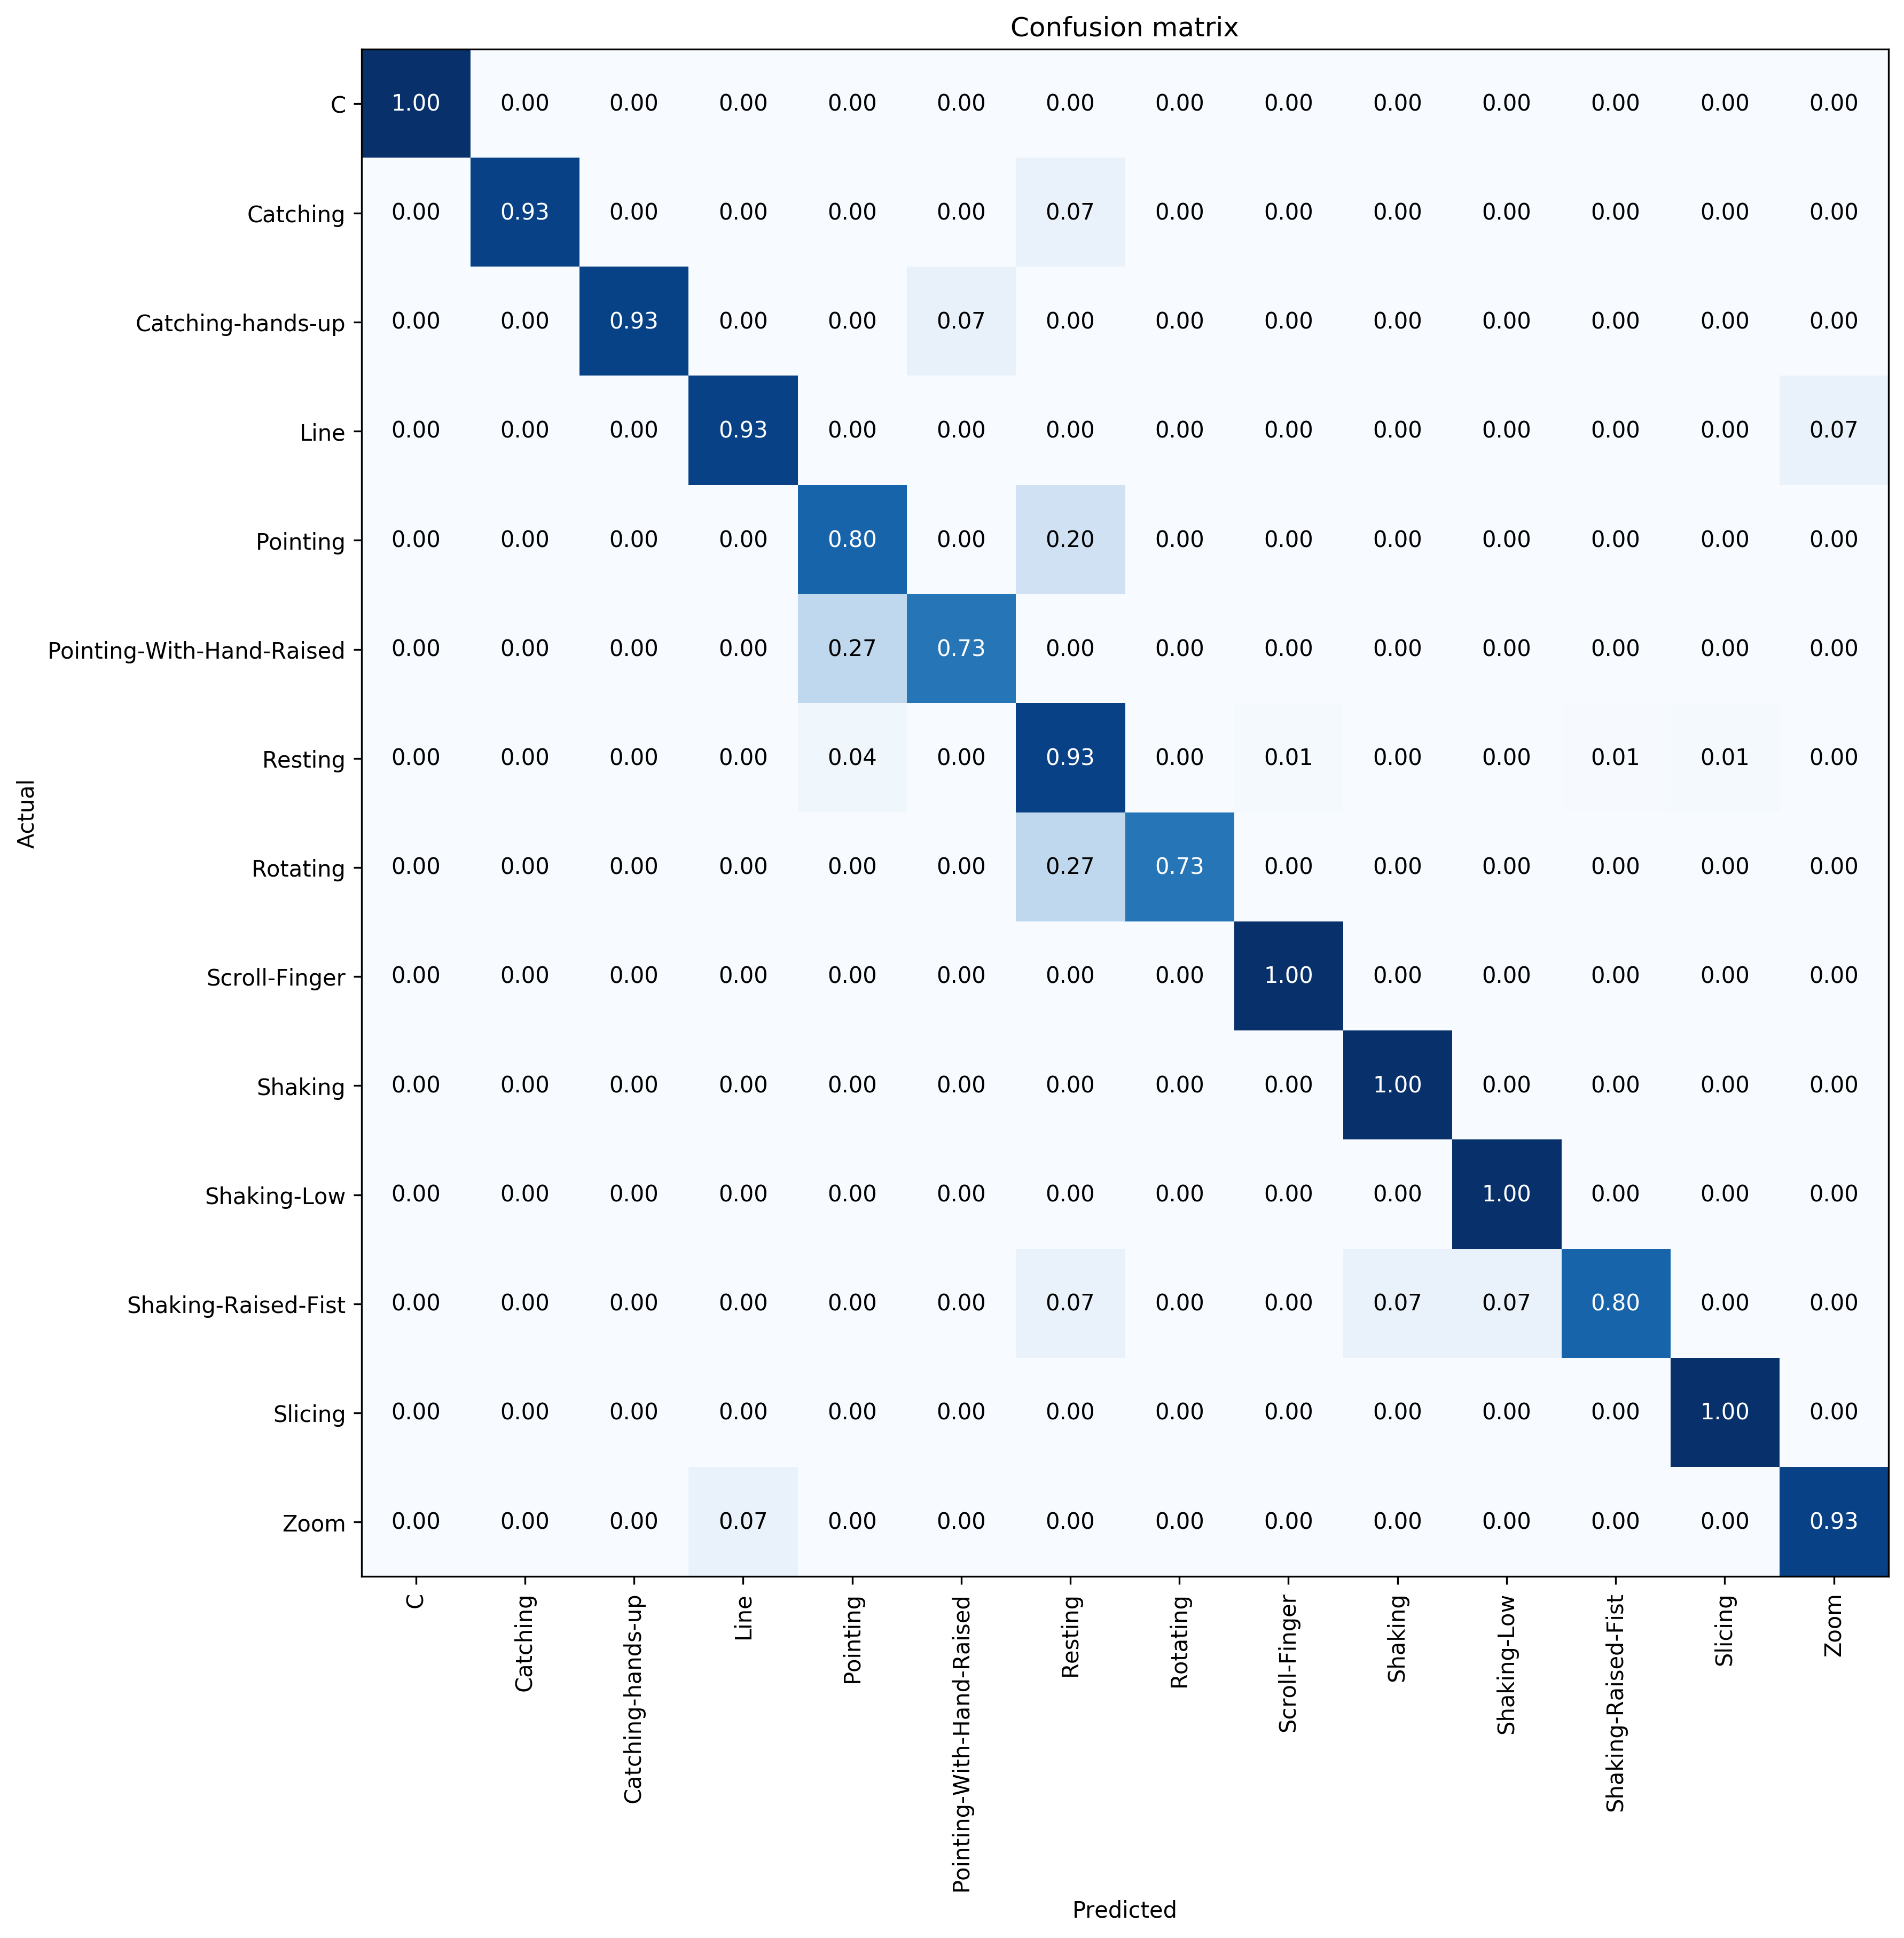

In [94]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

### Round 6 - 1080px (full size, original images)

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 779, y: 779)
Validation set len is: (x: 355, y: 355)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


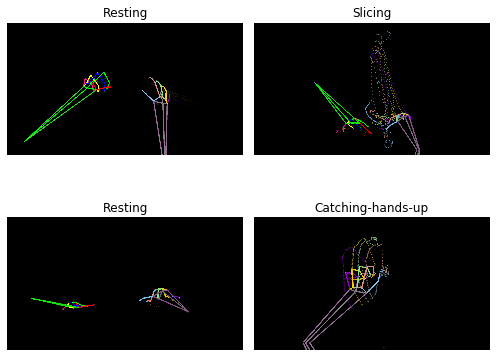

In [95]:
bs=4
img_size=None # leave the default 1920x1080 16:9 rectangular aspect ratio
data = create_dataset(bs, img_size)
learn.data = data

In [96]:
train_round=6
learn.freeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

True a


Batch  shape: torch.Size([4, 3, 1080, 1920])
Image  shape: torch.Size([3, 1080, 1920])
Labels shape: torch.Size([4])
Label[0]: 6 -> Resting
Label[2]: 6


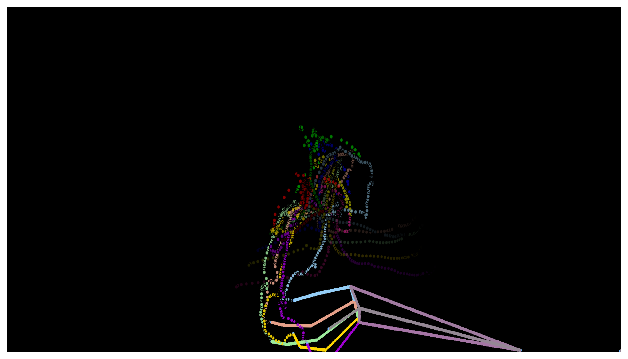

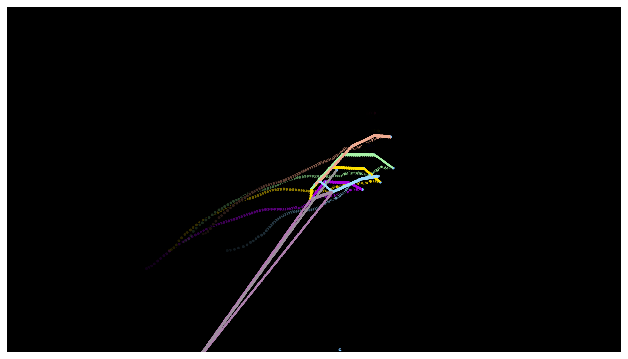

In [97]:
show_augmented_images()

In [98]:
show_hyperparams()

Batch size: 4, image size: None, learning rate: 0.0001


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


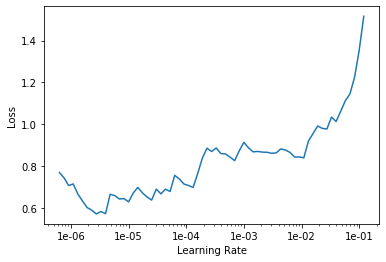

In [99]:
learn.lr_find()
learn.recorder.plot()

In [100]:
lr=1e-3

Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-None-6a-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [17890, 16841]


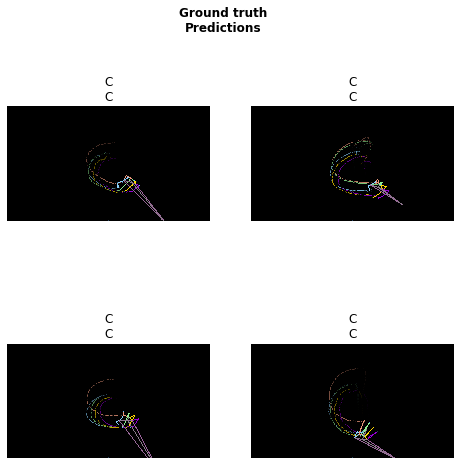

In [101]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

In [102]:
train_round=6
learn.unfreeze()
model_frozen, model_frozen_letter = is_frozen(learn)
print(model_frozen, model_frozen_letter)

False b


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


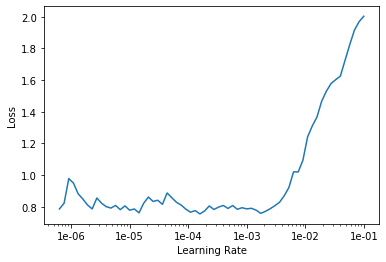

In [103]:
learn.lr_find()
learn.recorder.plot()

In [104]:
lr=1e-5

In [105]:
show_hyperparams()

Batch size: 4, image size: None, learning rate: 1e-05


Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-None-6b-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [18618, 1777]


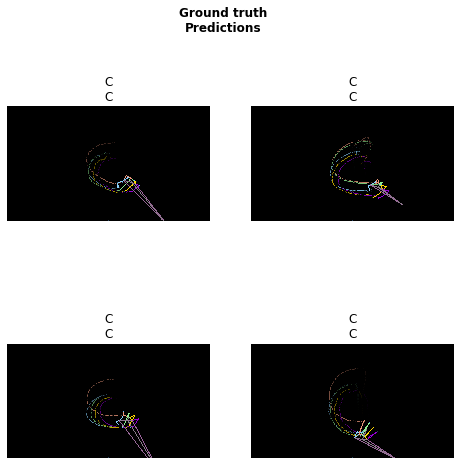

In [106]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr)

Learner object has path in: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models (which can be readonly, so we need to change it...)
Learner object new path is: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models
Saving models with prefix: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-None-6b-2020-02-18_18.27.35


nvidia-smi memory usage/increment: [18618, 16841]


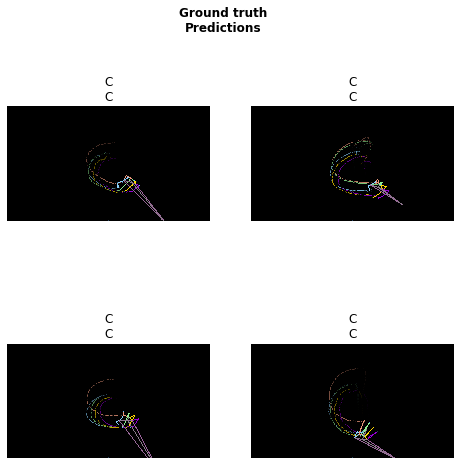

In [107]:
do_fit_fc(str(train_round) + model_frozen_letter, epochs=10, lr=lr/10)

Interpreting results and plotting top losses for stage-6


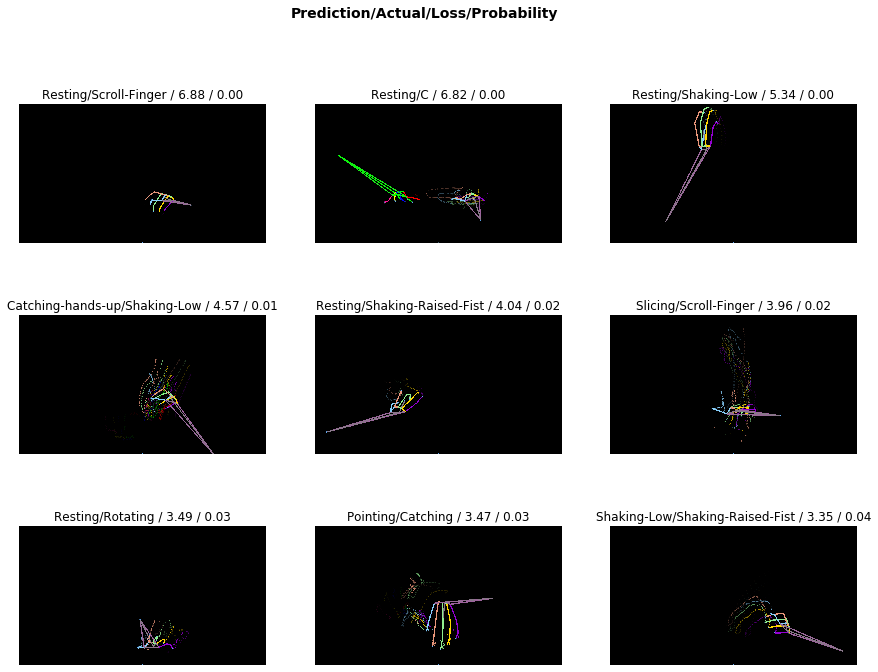

In [105]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-6


[('Resting', 'Pointing', 6),
 ('Pointing-With-Hand-Raised', 'Pointing', 4),
 ('Rotating', 'Resting', 4),
 ('Pointing', 'Resting', 3),
 ('Resting', 'Scroll-Finger', 2),
 ('Resting', 'Slicing', 2)]

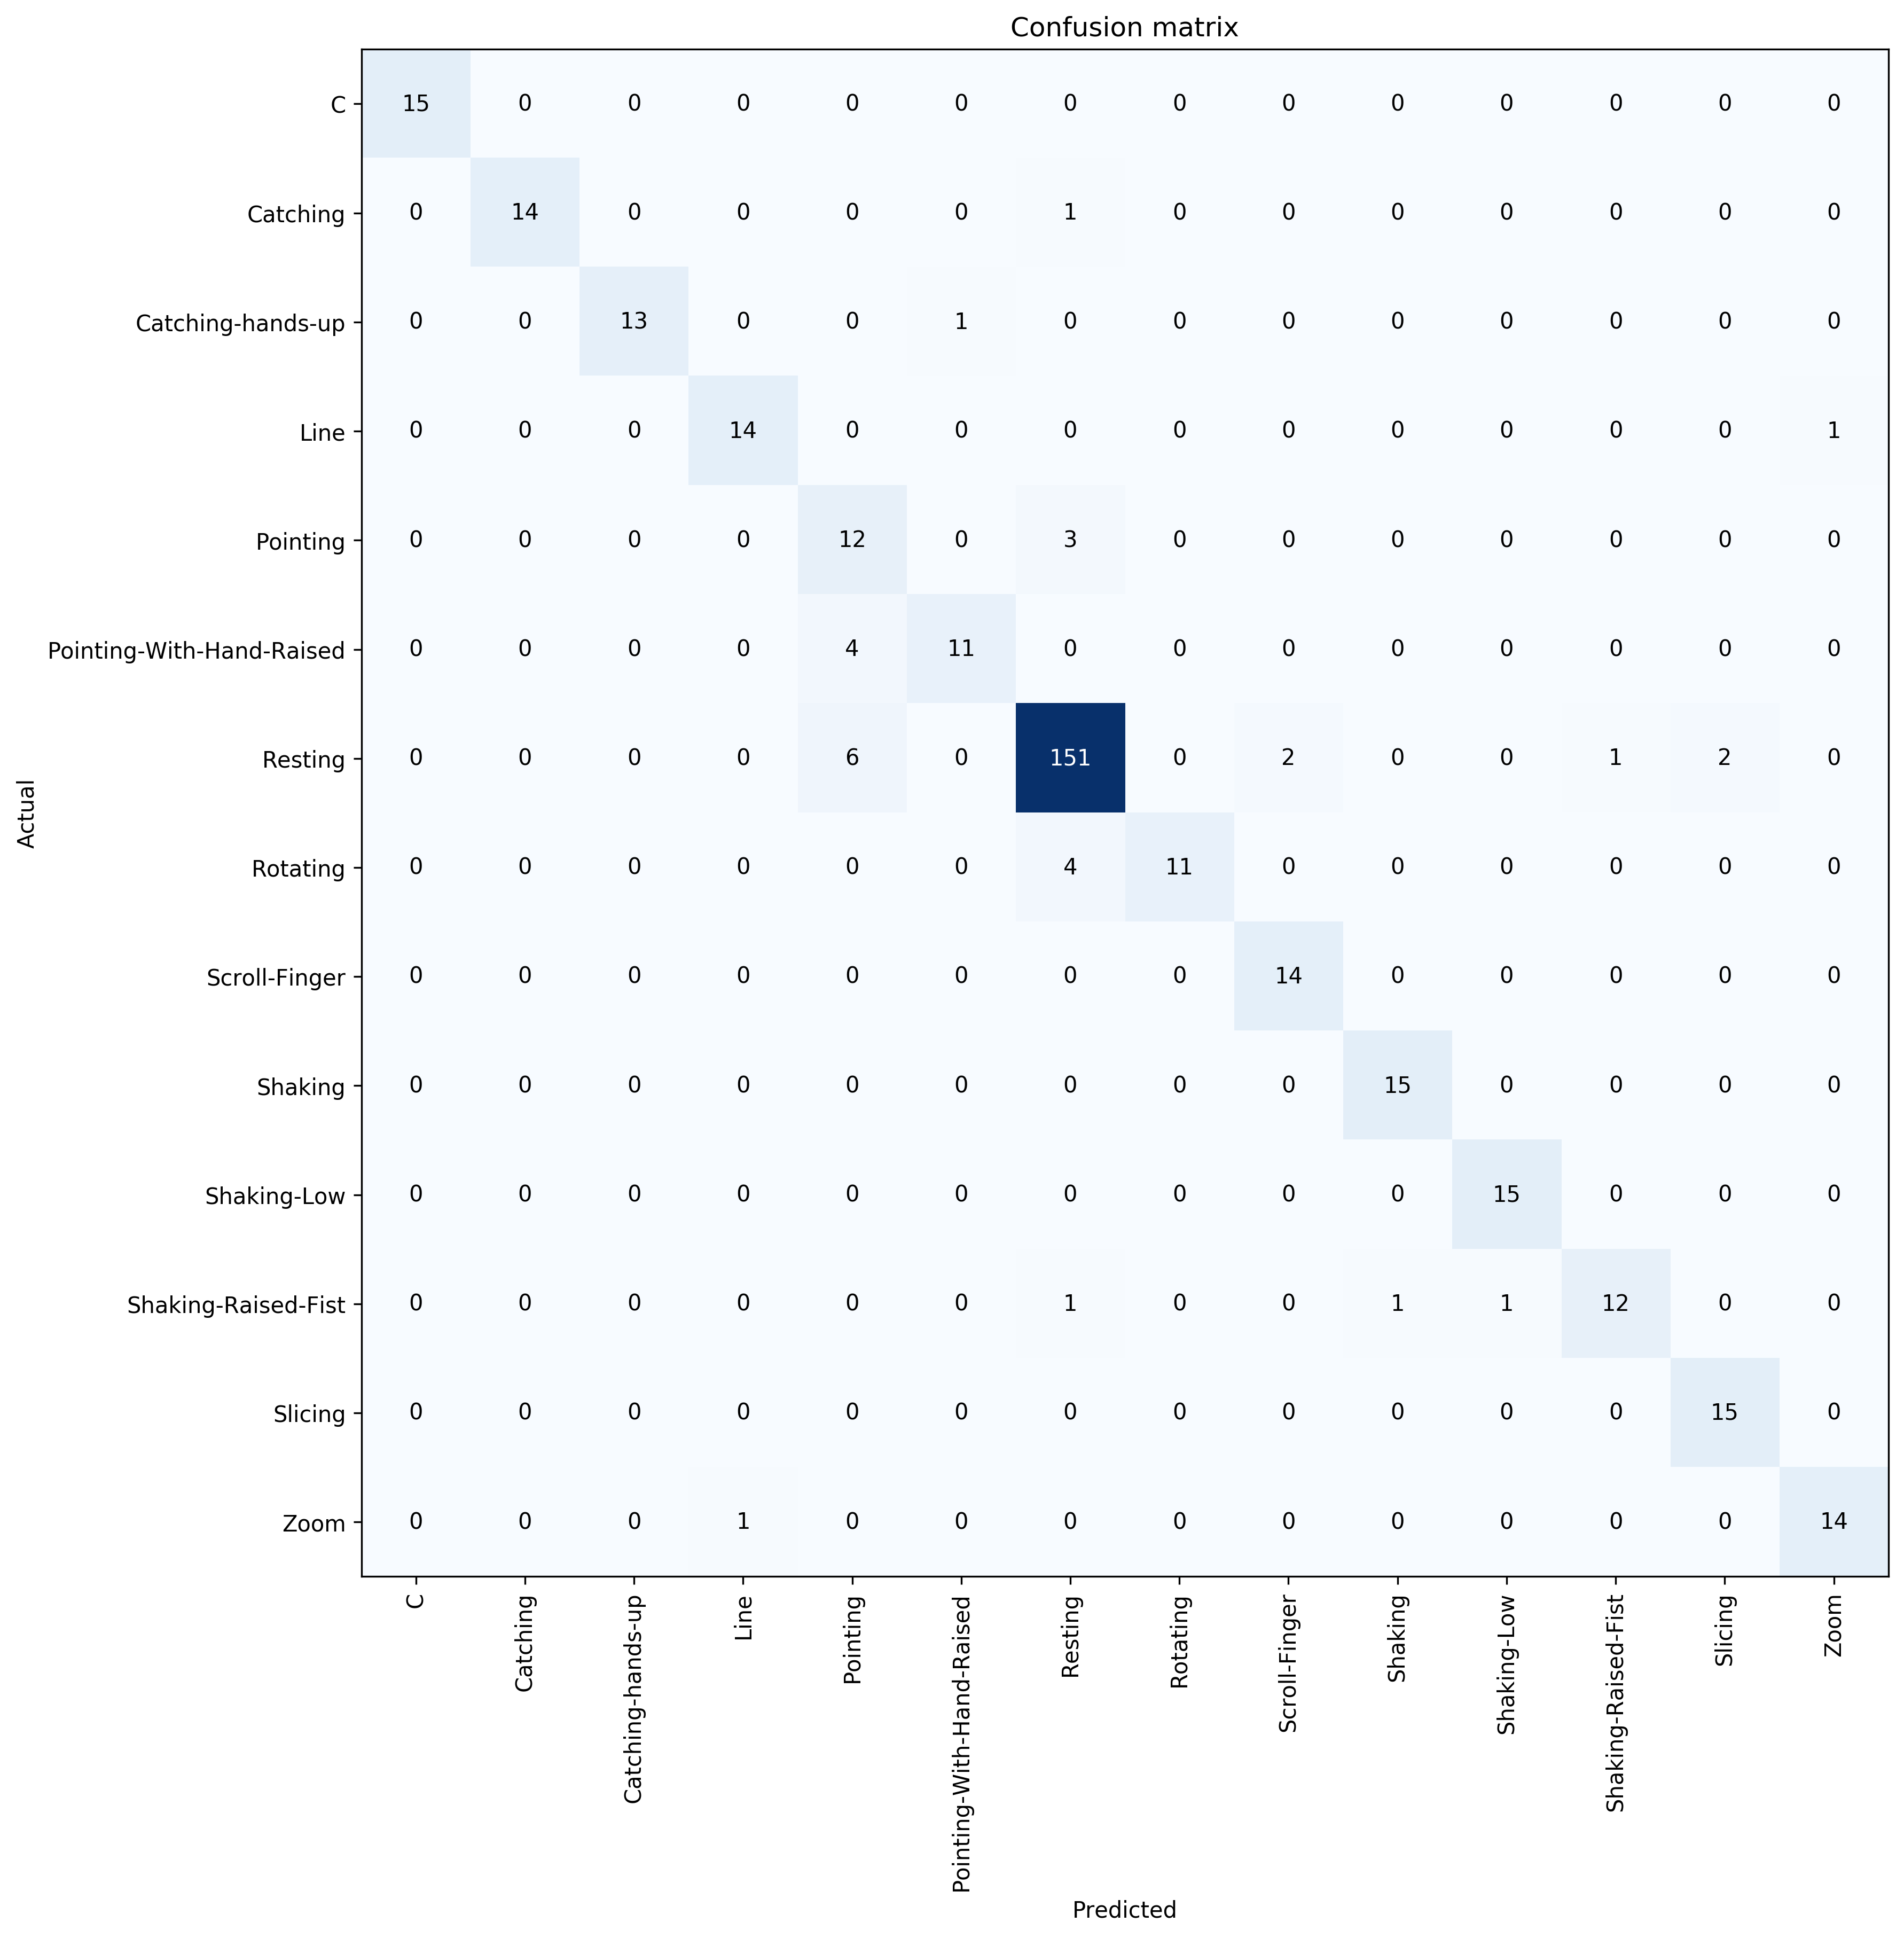

In [108]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-6


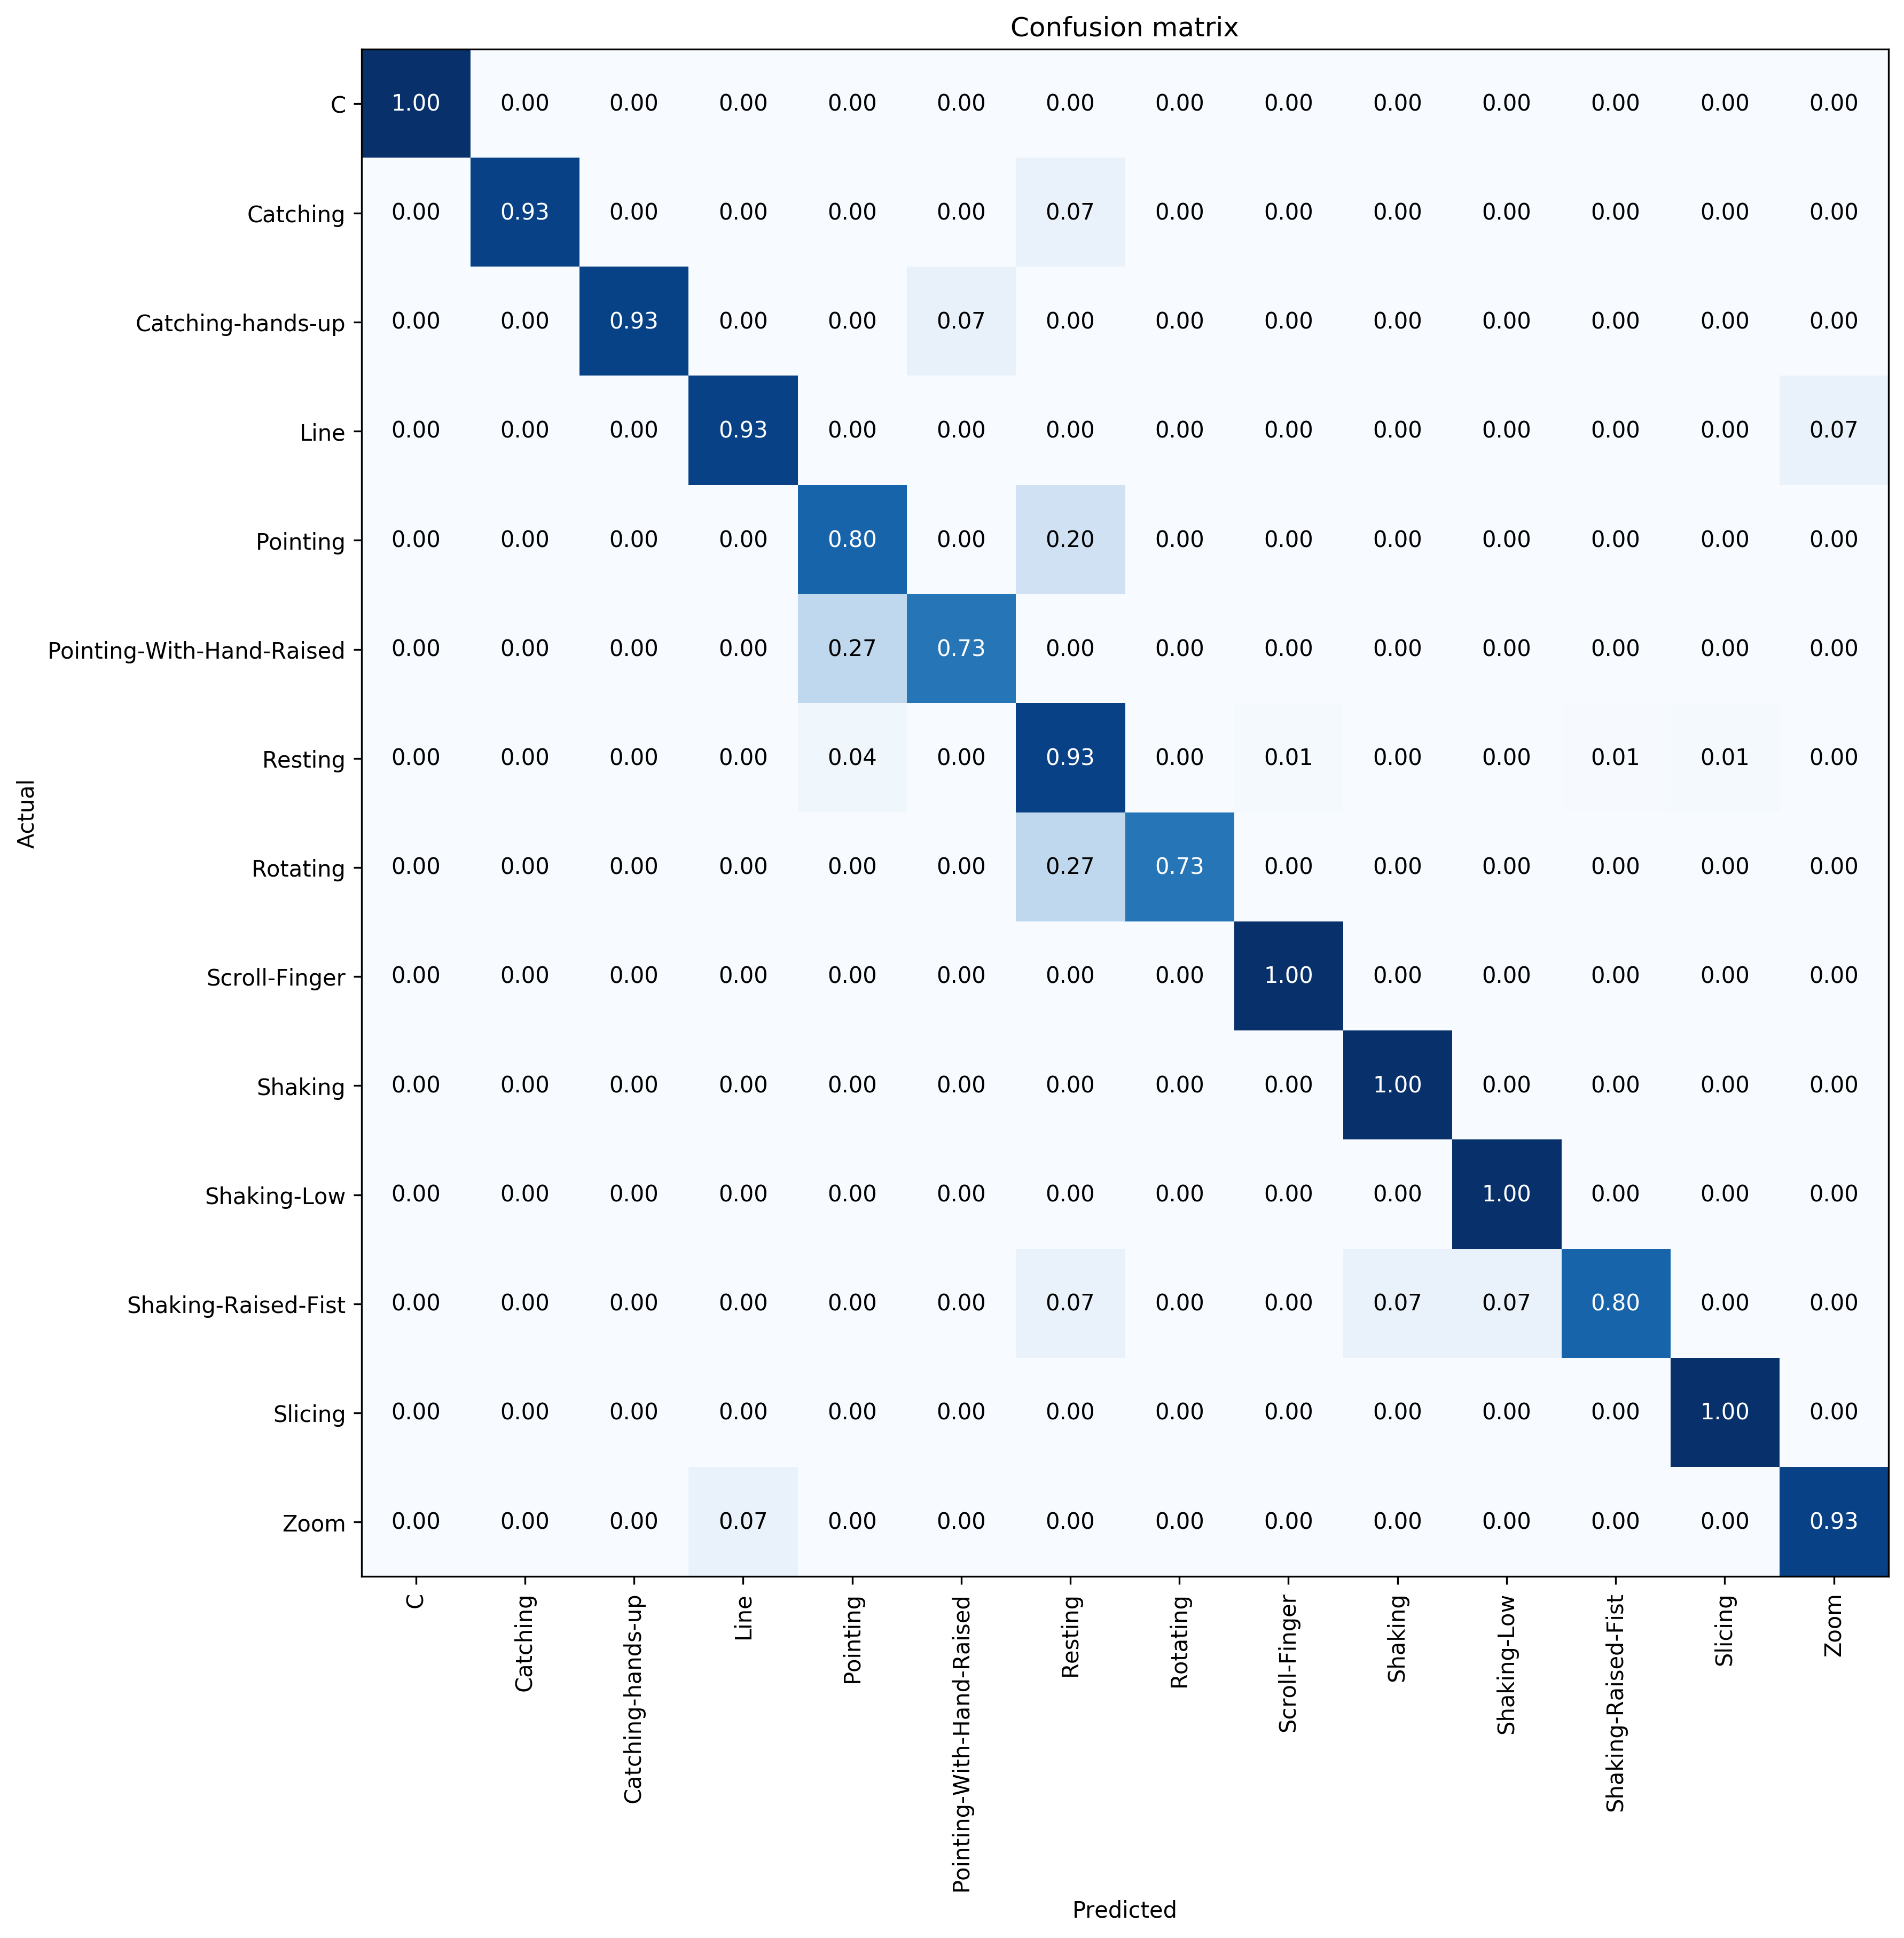

In [109]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

In [107]:
acc = evaluate_model_from_interp(interp, data)

Interp has 339 ground truth labels: tensor([ 1,  7,  6,  7,  4,  6, 10, 13,  5,  8,  6,  1,  9,  6,  6, 11, 12,  7,
         5,  0,  7,  0,  7,  6,  7,  2,  1,  6,  7,  6,  6,  6,  3,  6,  6,  3,
         6,  6,  7,  6,  6,  6,  6,  6,  4,  9,  6,  6,  7,  6, 10,  6,  1,  6,
         6,  1, 12,  6,  6,  2,  0,  8,  3,  6,  6,  6,  6,  2,  3,  6,  6, 10,
         2,  1,  7, 13,  6,  6, 13,  6,  6,  3,  6,  6,  3,  6,  6,  9,  0,  6,
         4,  6, 13,  6, 11, 13,  6,  3, 11,  2,  7,  6,  6,  6,  6, 12,  6,  7,
         6,  6,  9,  6,  8,  4,  6,  6,  6,  3,  1,  6,  1,  3,  2,  0,  1,  9,
         6, 10,  7, 12, 11,  6, 13,  6,  6,  6,  9,  6,  5, 11,  3,  3, 13,  4,
        12,  6,  4,  1,  6,  6,  5,  6,  6,  6,  0,  6,  3,  7, 11,  8,  6, 11,
         6,  3,  6, 11,  1,  6,  9,  9,  8, 12,  4,  1, 11,  6,  6,  7, 12,  7,
         6,  6,  2, 12,  1, 10,  0,  6,  6,  3,  2,  6,  6,  8,  0, 10,  4, 13,
         6,  3,  6, 12,  6,  6,  1,  3,  9,  6,  8,  6,  6,  6, 13,  6, 11,  9,
    

# Reload the best model

### Best model is @ Round 5 - 810px - epoch 9 - 91.83% accuracy

In [110]:
# resnet-50-img_size-810-5b-2020-02-18_18.27.35_9.pth
load_img_size = 810
load_name     = '5b'
load_currtime = '2020-02-18_18.27.35'
load_epoch    = 9
model_name_to_load = str(savepath) + '/' + model_name + '-img_size-' + str(load_img_size) + '-' + load_name + '-' + load_currtime + '_' + str(load_epoch)
print(f'Loading: {model_name_to_load}')

learn.load(model_name_to_load)
learn.path = savepath # don't forget this if you want to be able to conclude an epoch with data from a read-only directory!
learn.data = data     # this one is necessary...
print(f'Save path: {savepath}')

Loading: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models/resnet-50-img_size-810-5b-2020-02-18_18.27.35_9
Save path: /home/ranieri/dataset/dynamic-hand-gestures-dataset-with-colored-fingers-and-tip-traces-split-as-in-the-paper/../models


# Recreate the DataBunch as in Round 5 with the correct image size

### It's important to validate the model with the correct image size (810px in this case), otherwise accuracy will be certainly lower

The dataset has 14 (14) classes: ['C', 'Catching', 'Catching-hands-up', 'Line', 'Pointing', 'Pointing-With-Hand-Raised', 'Resting', 'Rotating', 'Scroll-Finger', 'Shaking', 'Shaking-Low', 'Shaking-Raised-Fist', 'Slicing', 'Zoom']
Training   set len is: (x: 779, y: 779)
Validation set len is: (x: 355, y: 355)
Dataset image size is  (train: torch.Size([1080, 1920]), valid: torch.Size([1080, 1920]))


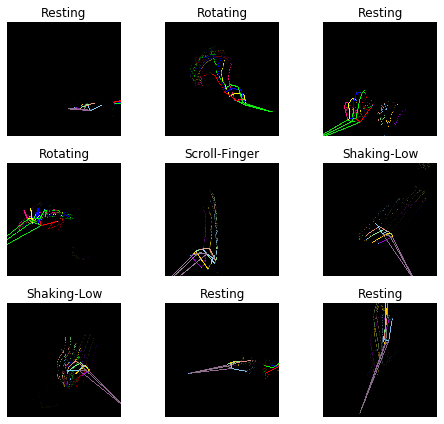

In [115]:
bs=16
img_size=810
data = create_dataset(bs, img_size)
learn.data = data

Interpreting results and plotting top losses for stage-6


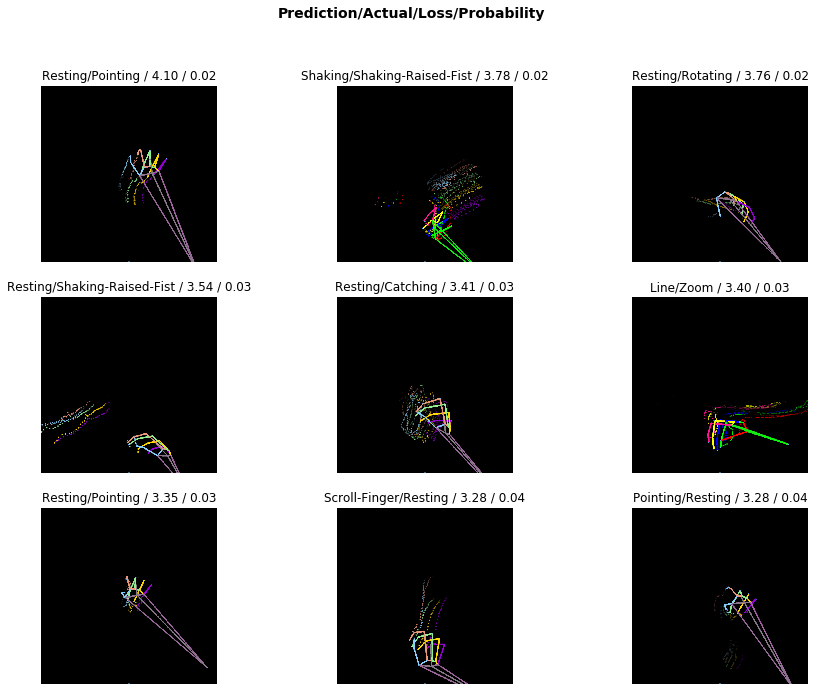

In [116]:
print('Interpreting results and plotting top losses for stage-' + str(train_round))
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

Plotting confusion matrix/top confused for stage-6


[('Resting', 'Pointing', 6),
 ('Pointing-With-Hand-Raised', 'Pointing', 4),
 ('Rotating', 'Resting', 4),
 ('Pointing', 'Resting', 3),
 ('Resting', 'Scroll-Finger', 2),
 ('Resting', 'Slicing', 2)]

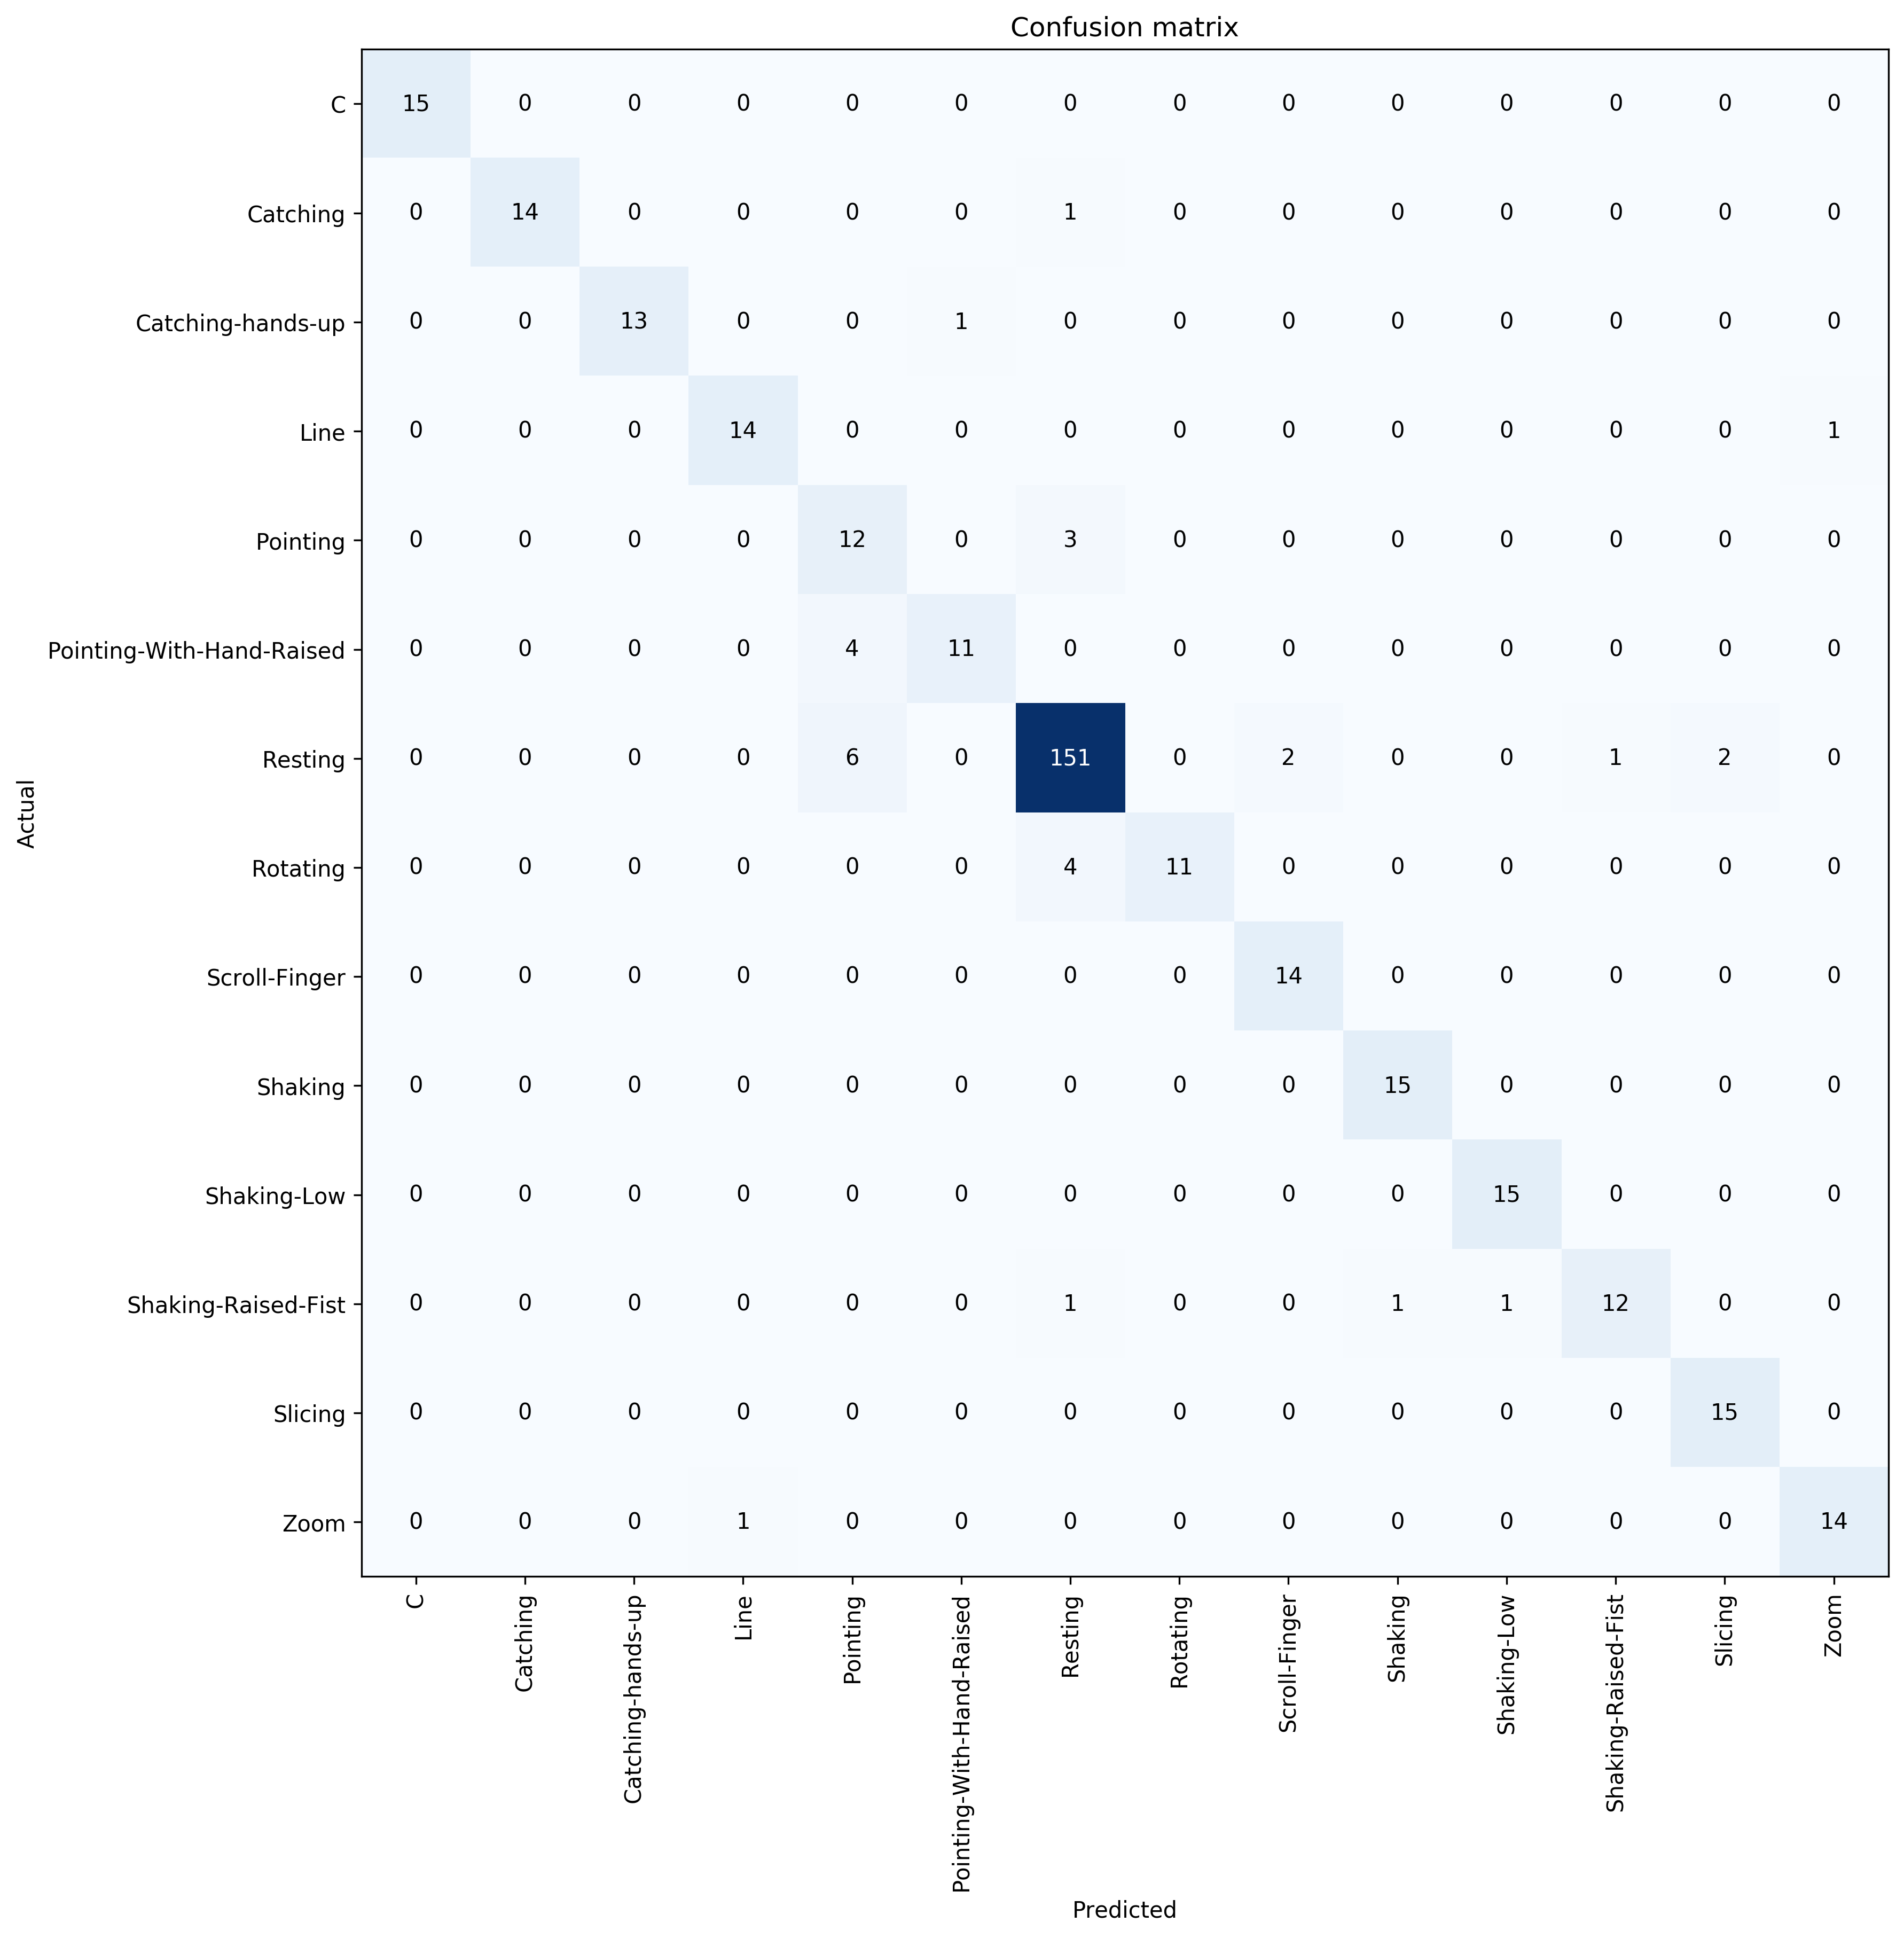

In [117]:
print('Plotting confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(figsize=(12,12), dpi=300)
interp.most_confused(min_val=2)

Plotting normalized confusion matrix/top confused for stage-6


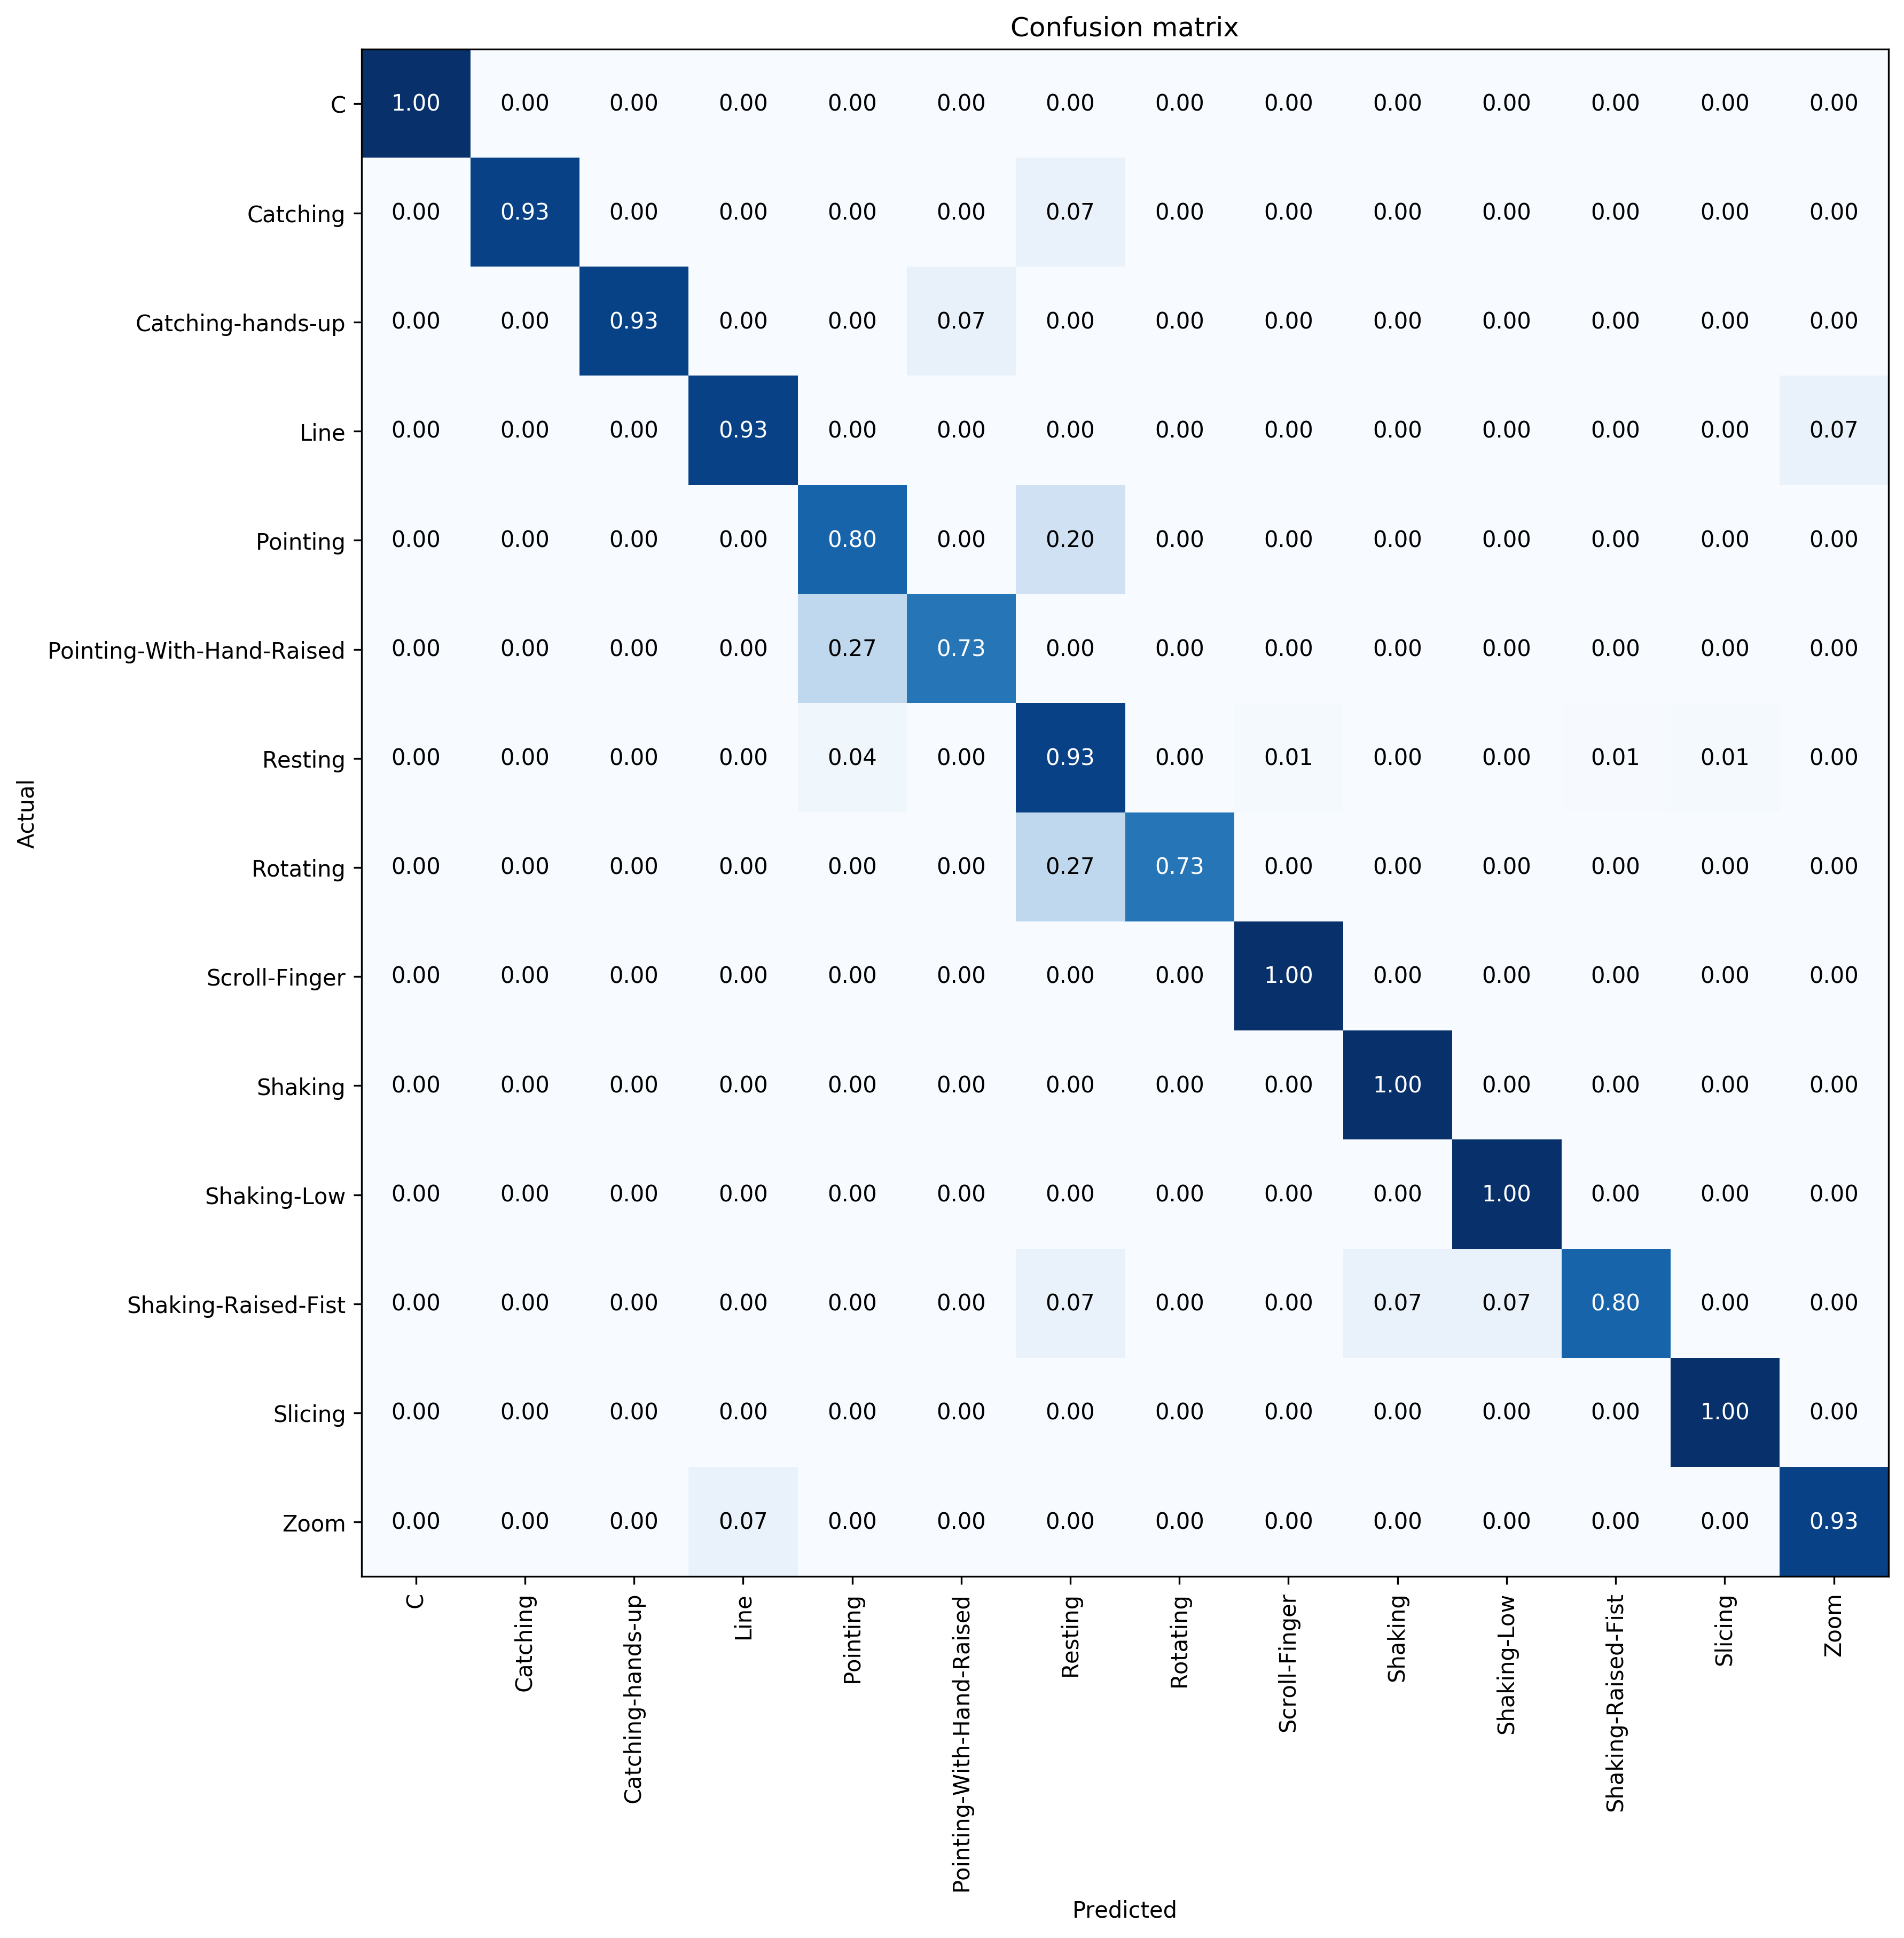

In [118]:
print('Plotting normalized confusion matrix/top confused for stage-' + str(train_round))
interp.plot_confusion_matrix(normalize=True, figsize=(12,12), dpi=300)

In [119]:
acc = evaluate_model_from_interp(interp, data)

Interp has 355 ground truth labels: tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
    